# Prediction Learning Agent
#### Experiment: Teach an agent to play optimal Atari Pong from pixels
#### Goal: Outperform state-of-the-art RL (A3C, DQN) in time-to-solve AND skill (lose fewer points)
#### Approach: Model-based learning via ensembles of linear models, operating on object-level features generated by image segmentation.
## Progress:
Key:

X : Done

\- : In progress

\> : Next step

[X] Generate comparison benchmarks

    [X] DQN
    
    [X] A3c

[X] Setup debugging environment

    [X] Render frames of Pong
    
    [X] Overlay image segmentation
    
    [X] Data retrieval and preprocessing
    
[ ] Segment objects in environment

    [X] Use pixel diffs to narrow areas of interest
    
    [X] Create online representations of objects
    
    [X] Track objects
    
    [ ] Trim redundant representations
    
    [ ] Handle multiple objects of same class
    
    [ ] Heuristics for object permanence across frames
  
[-] Model learning

    [X] Integrating linear model from Scikit-Learn
    
    [>] Asking for predicitons from models
    
    [-] Generating new models
    
    [ ] Evaluating existing model performance
    
    [ ] Record states where model performs well
    
    [ ] Deduce key states for specific model performance

[  ] Agent policy

    [ ] Generate ambiguity-reducing actions by measuring model uncertainty
    
    [ ] Learn action-state mapping
    
    [ ] Conduct rollouts based on actions
    

In [149]:
# standard imports
import gym
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(threshold=np.inf) # Unlimited print length
plt.rcParams["figure.figsize"] = [7,6] # Make figures large

In [150]:
# Renders pixel arrays in a gif viewer
from JSAnimation.IPython_display import display_animation
from matplotlib import animation, patches
import matplotlib.pyplot as plt
from IPython.display import display
import sys

def display_frames_as_gifB(frames, rects = [], objects = []):
    """
    Displays a list of frames as a gif, with controls
    """
    count = len(frames)
    sys.stdout.write("Loading {} frames... ".format(count),)
    current_rects = []

    fig,ax = plt.subplots(1)

    patch = ax.imshow(frames[0],vmin=0, vmax=255,cmap='hot')
    ax.axis('off')
    # Create a Rectangle patch

    def animate(i):
        if i % int(float(count)/5.0) == 0 and i != 0:
            sys.stdout.write("{}%".format(int(float(i)/count*100)),)
            
        for rect in current_rects:
            rect.set_visible(False)

        patch.set_data(frames[i])
        if len(rects) == 0: return
        for cluster in rects[i]:
            edgecolor = cluster[4] if len(cluster) == 5 else 'g'
            rect = patches.Rectangle((cluster[0], cluster[1]),cluster[2]-cluster[0],cluster[3]-cluster[1],linewidth=1, edgecolor=edgecolor,facecolor='none')
            ax.add_patch(rect)
            current_rects.append(rect)

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames)-1, interval=60)
    display(display_animation(anim, default_mode='loop'))


In [151]:
# Data collection cell for testing
# Create environment
game_name = "Pong-v4"
env = gym.make(game_name)
state = env.reset()

frames = []
env.step(1) #Trigger env start
for i in range(100):
    env.step(0) # 0 = No-op 
    frame = env.render("rgb_array")
    #Convert frames to grayscale
    frames.append(cv2.cvtColor(frame,cv2.COLOR_RGB2GRAY))
frames = np.asarray(frames)
env.close()

# Remove background pixels for easier contour detection
# Randomly sample 5 frames and find color mode
import random
from collections import Counter
possible_backgrounds = []
for x in range(5):
    frame_num = random.randint(0,len(frames))
    frame = frames[frame_num].flatten()
    num = Counter(frame).most_common(1)
    possible_backgrounds.append(num[0][0])
background_color = Counter(possible_backgrounds).most_common(1)[0][0]
print("Background color", background_color)
for index,value in np.ndenumerate(frames):
    if value == background_color:
        frames[index] = 0 # set background pixels to black
        
# TODO: investigate vectorization for speed
# vecFunc = np.vectorize(lambda x: 0 if x == background_color else x)
# frames = vecFunc(frames).astype(np.uint8)
        
# Generate pixel diffs
# Organized as a list of 2D arrays (small images)
# grayscale pixel values from 0-255
diffs = []
for i in range(len(frames)):
    if i == 0: continue
    frame = frames[i] - frames[i-1]
    diffs.append(frame)

[2017-09-18 16:20:58,228] Making new env: Pong-v4


('Background color', 87)


Loading 100 frames... 20%40%60%80%


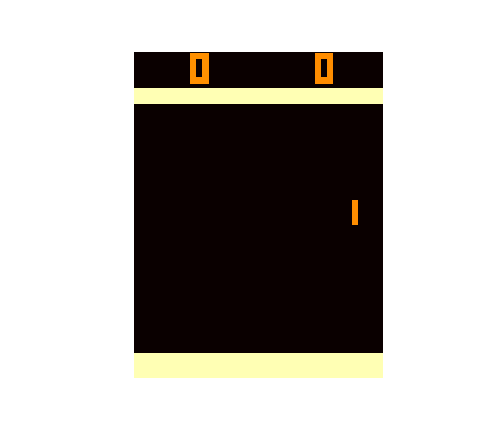
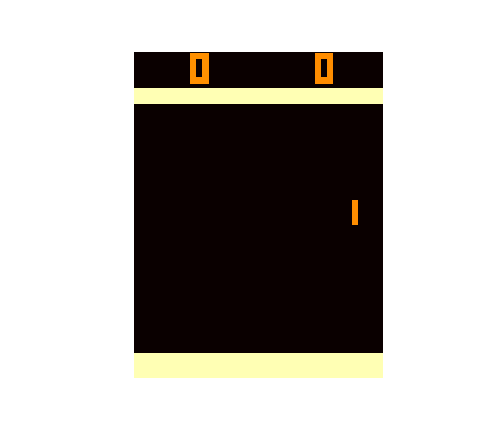
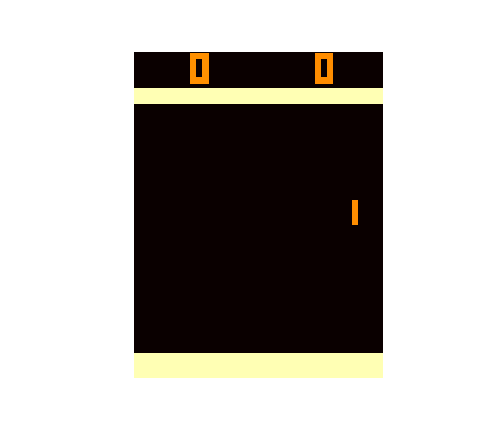
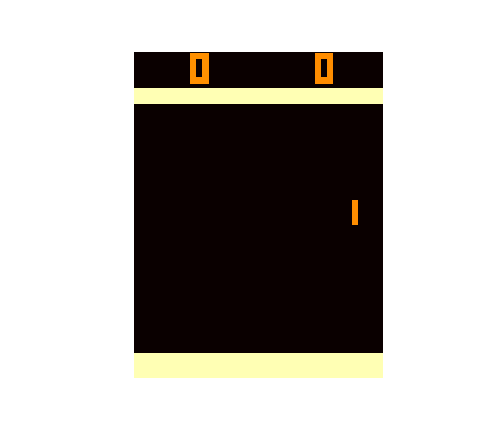
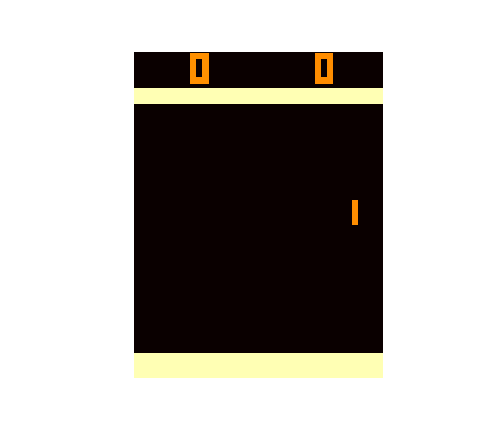
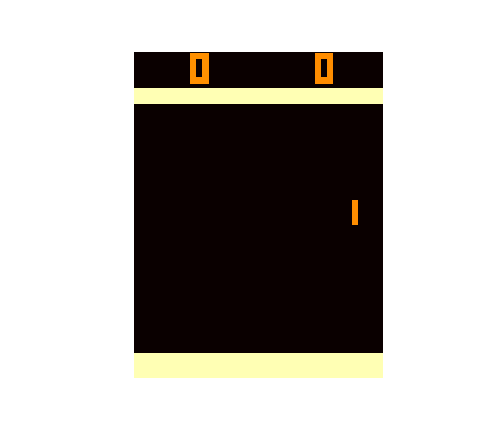
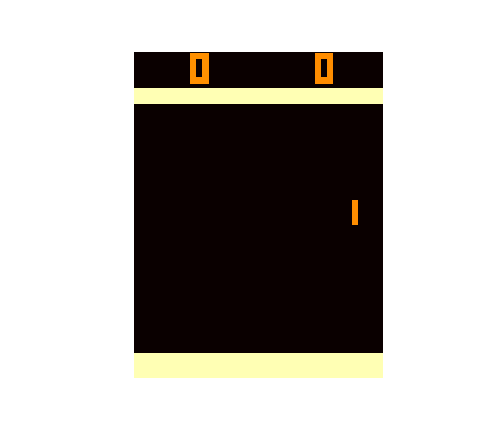
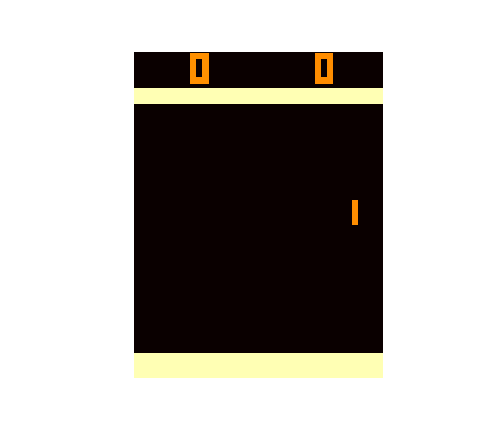
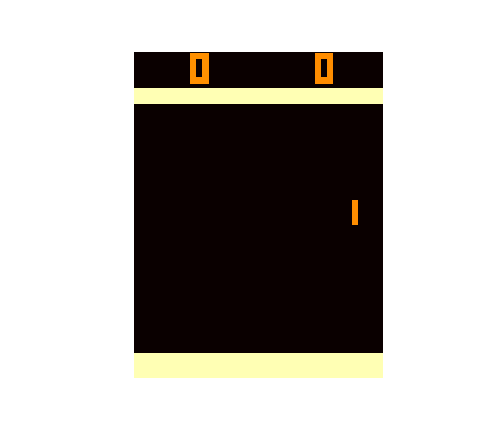
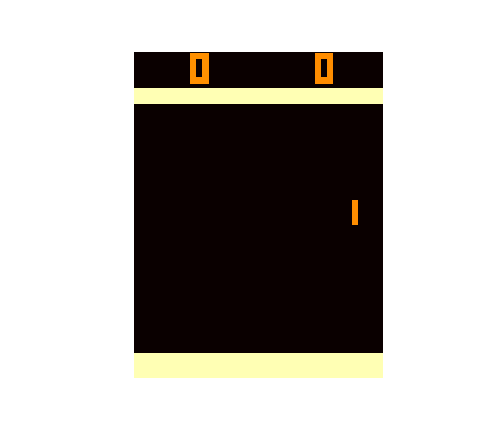
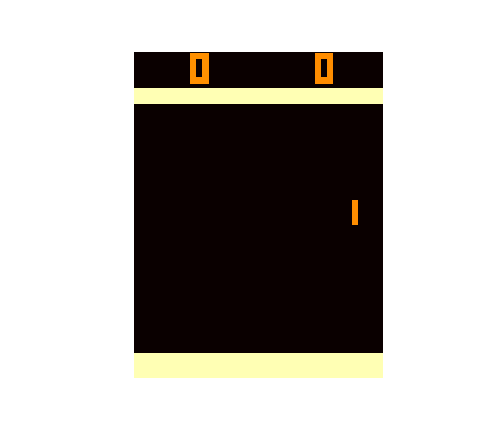
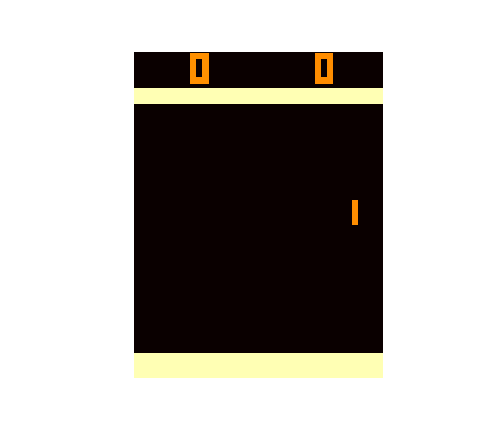
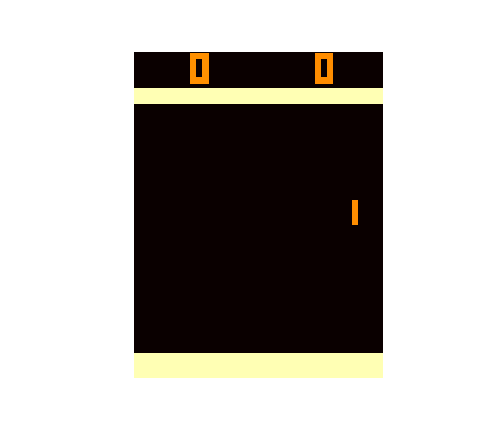
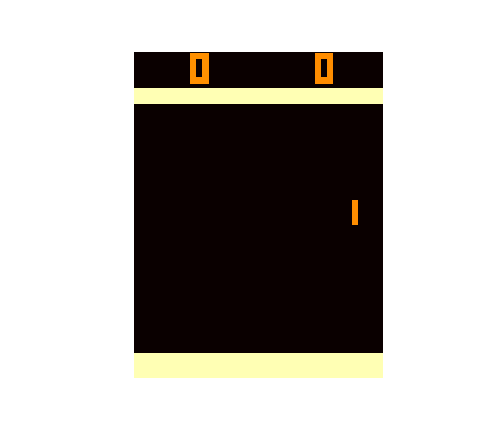
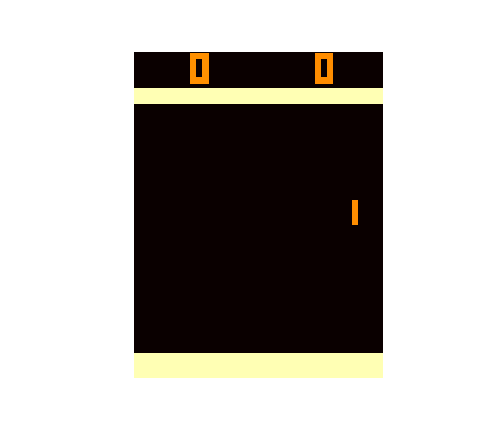
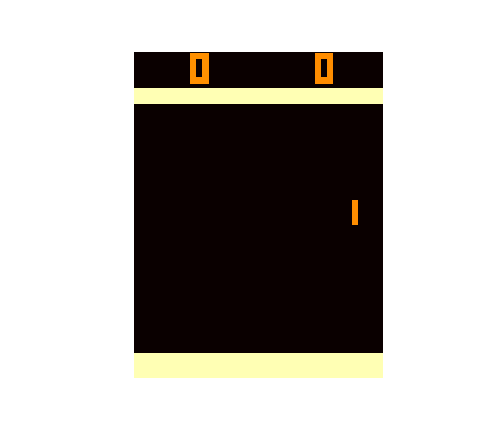
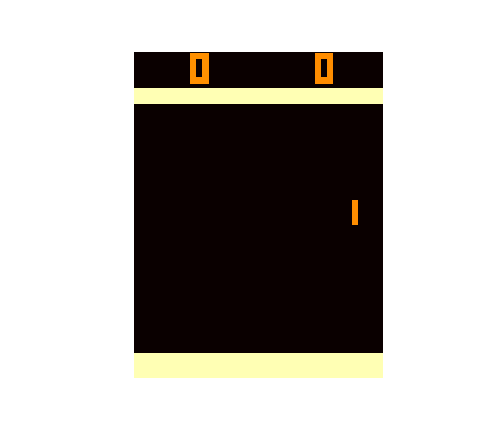
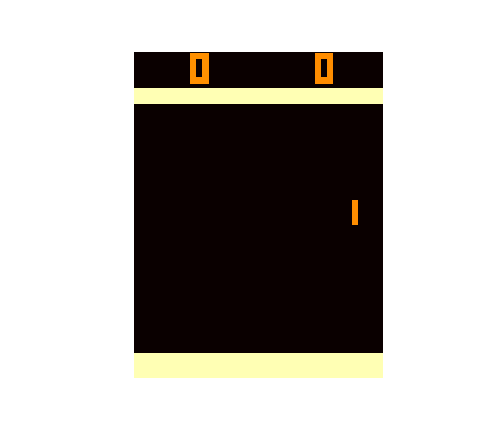
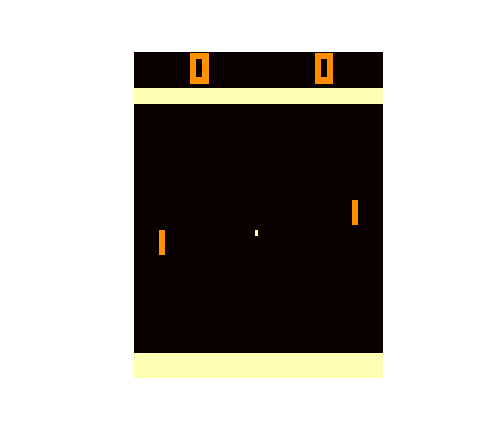
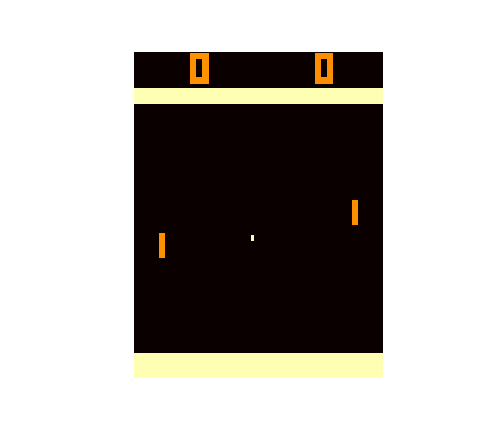
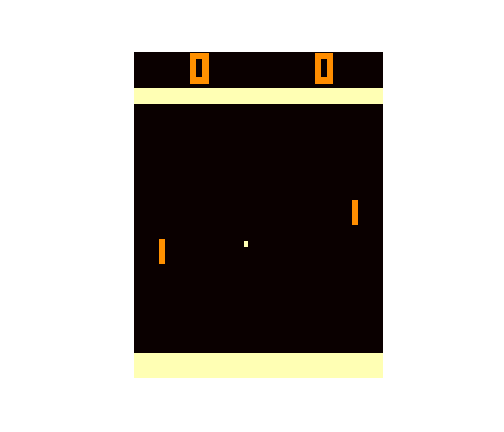
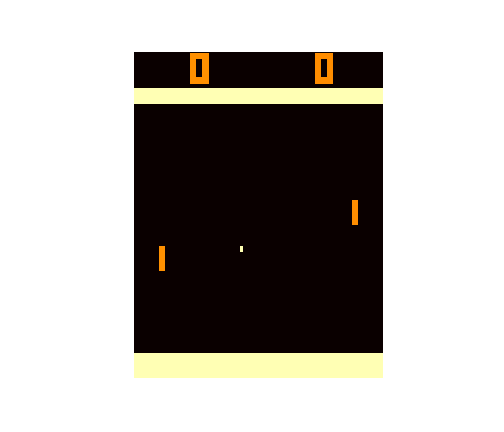
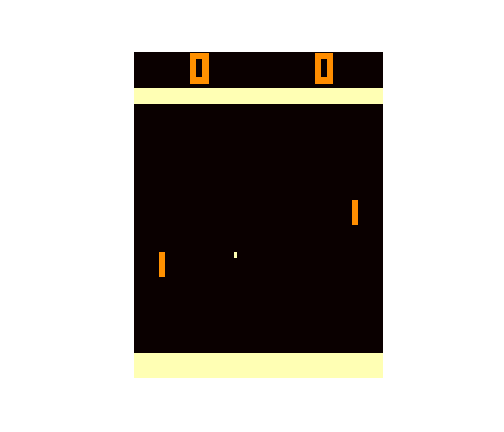
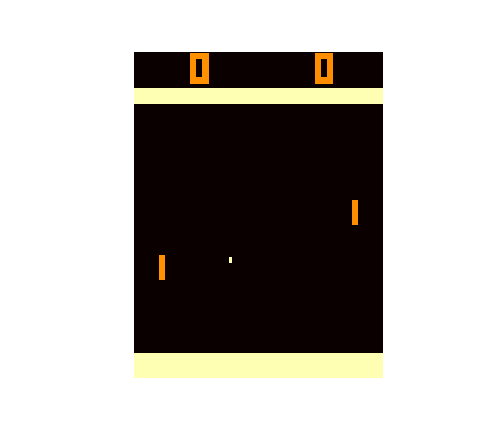
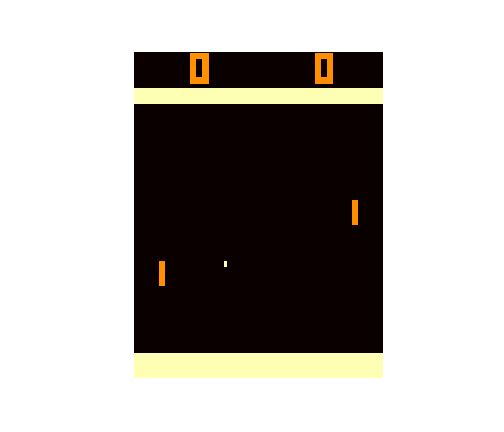
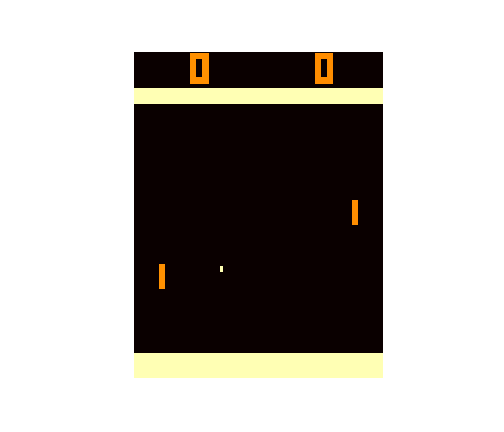
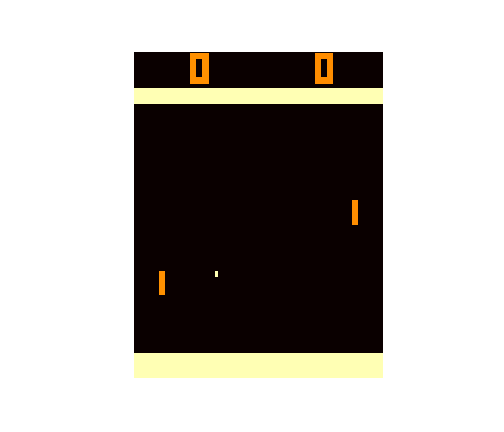
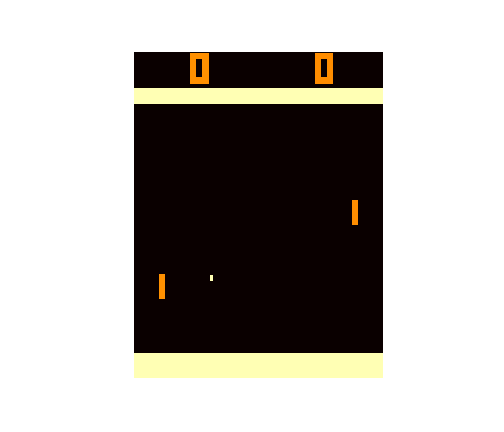
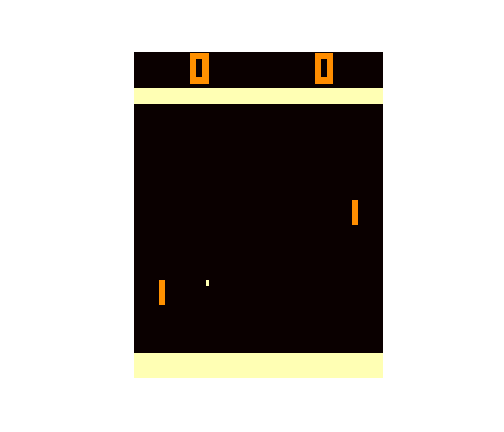
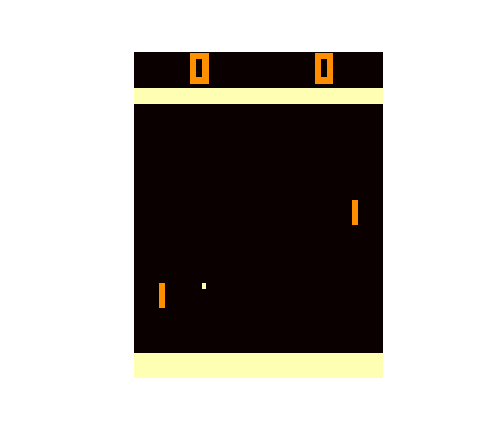
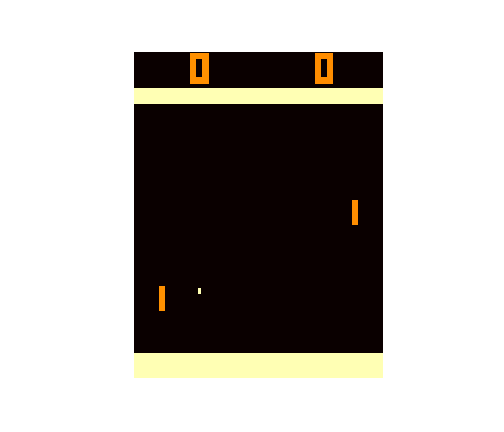
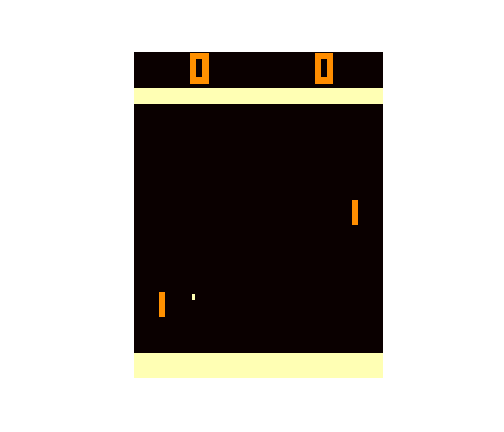
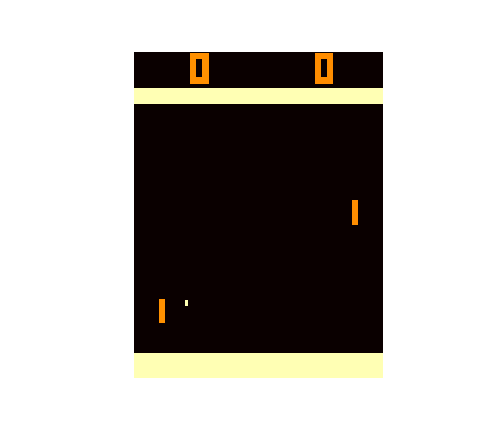
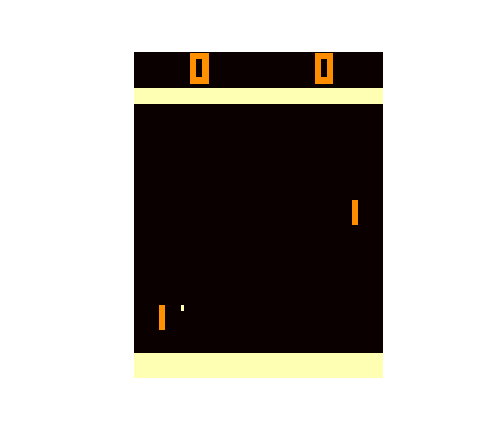
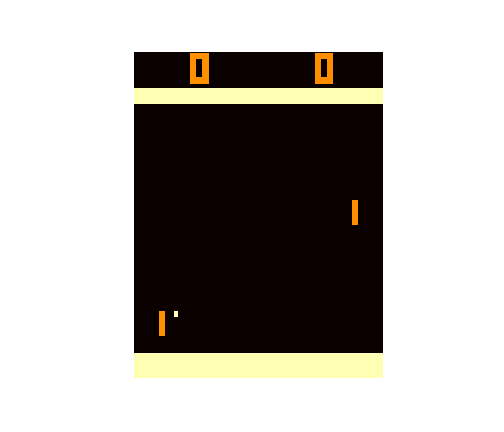
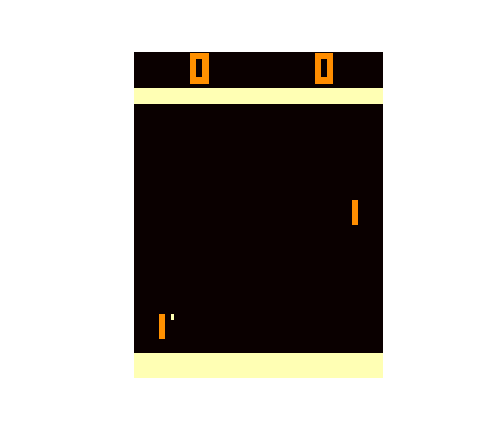
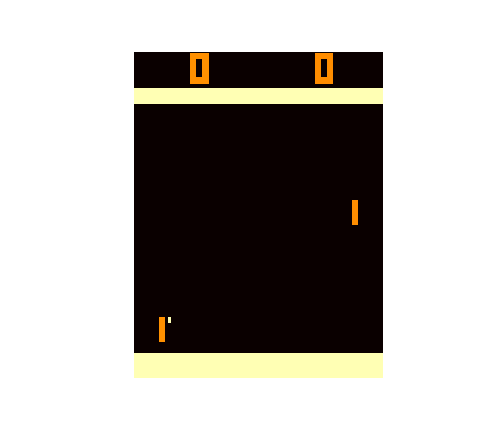
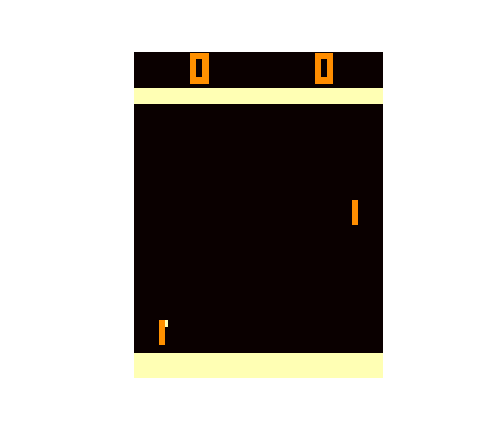
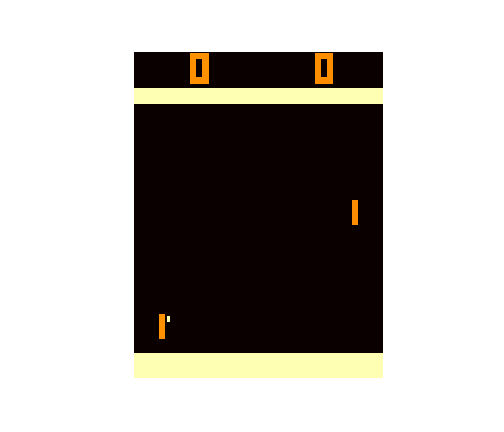
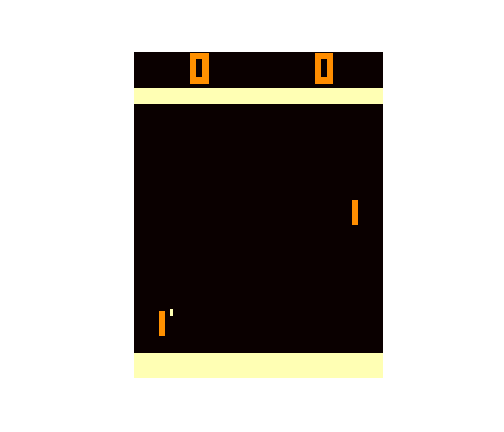
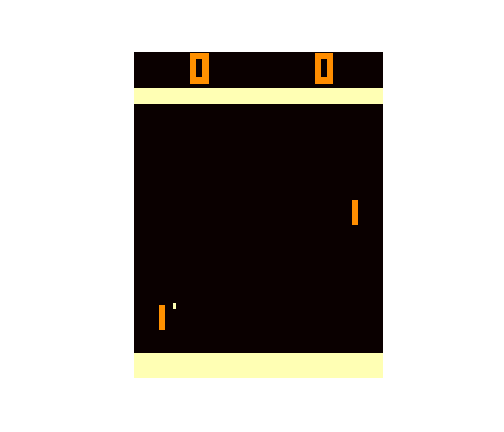
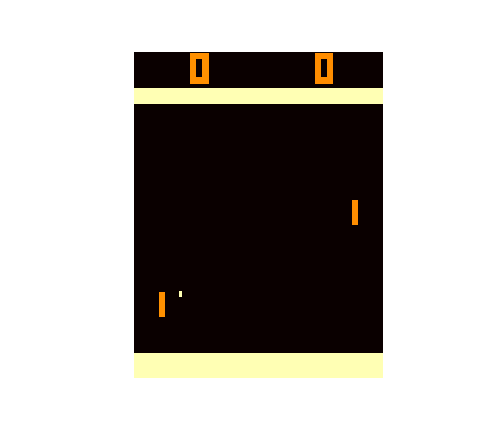
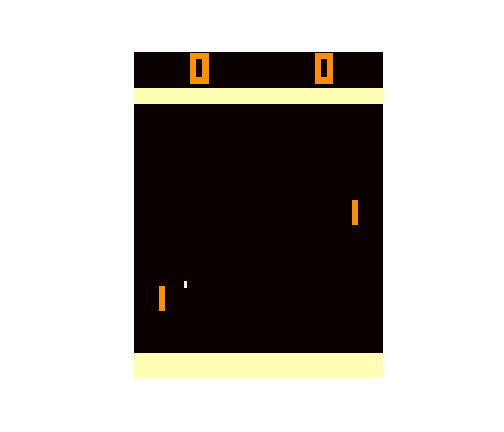
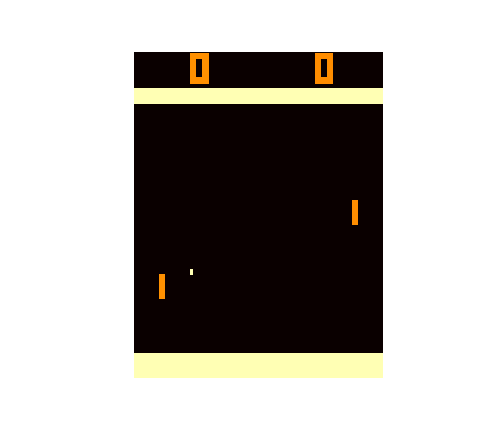
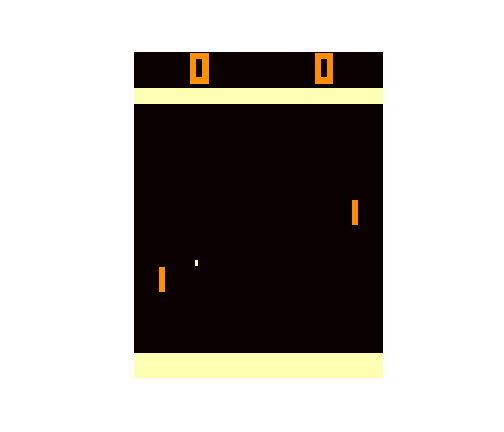
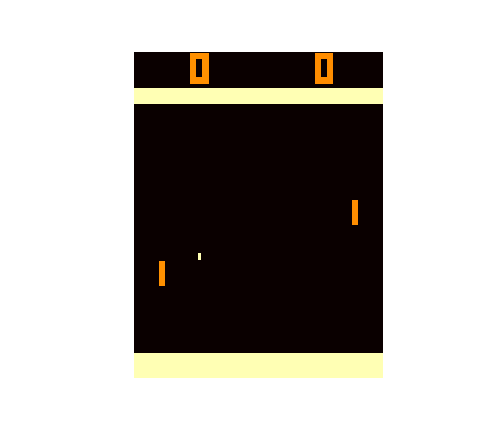
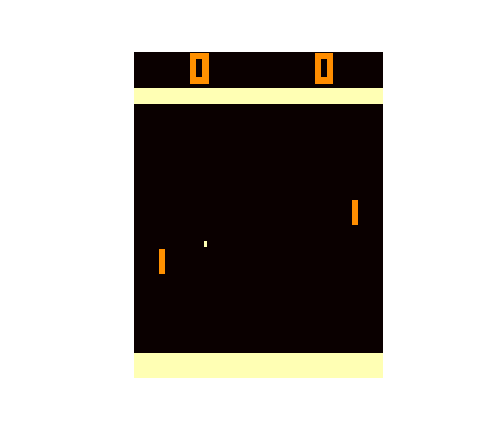
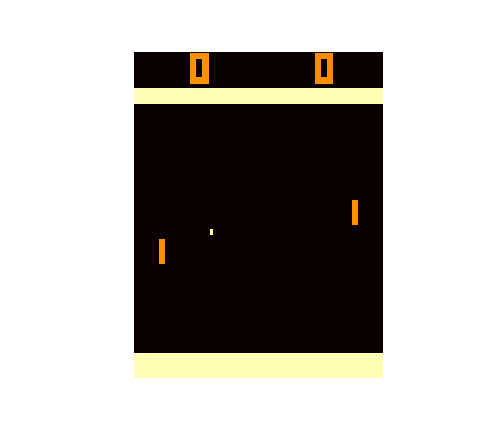
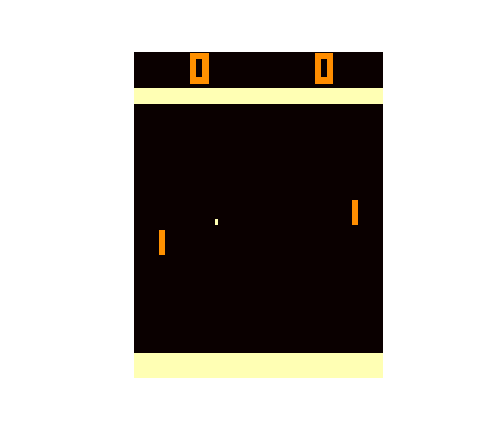
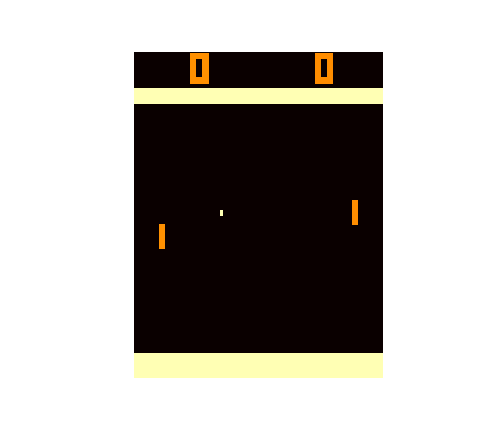
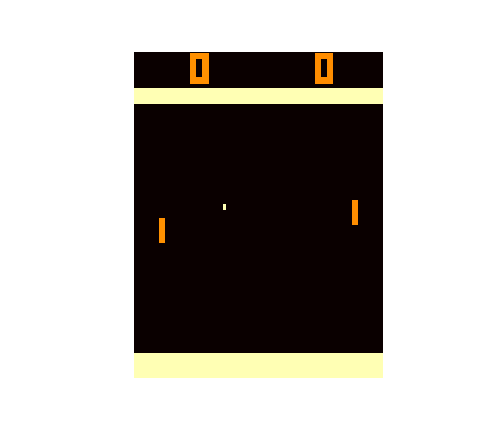
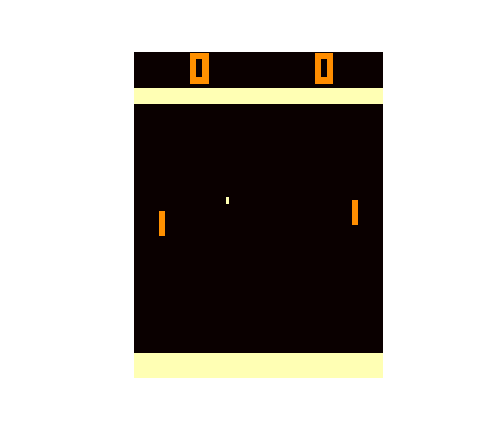
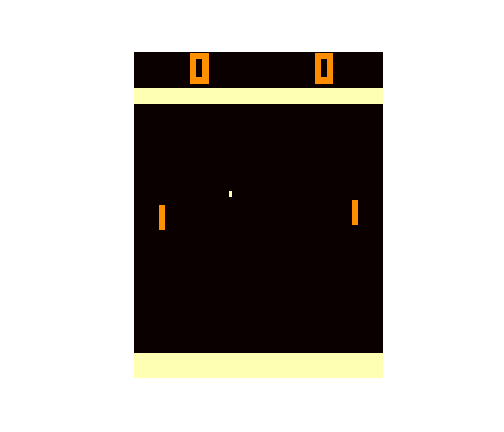
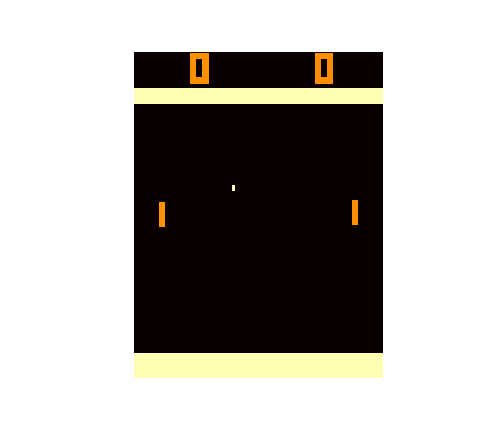
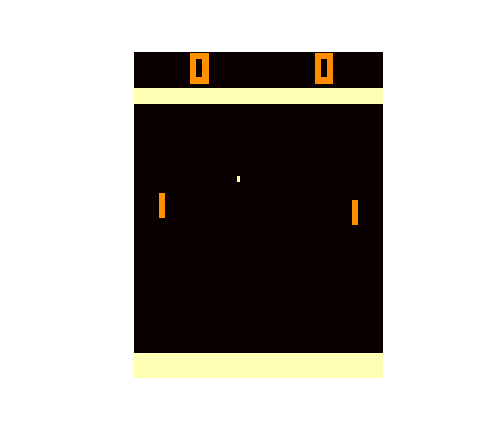
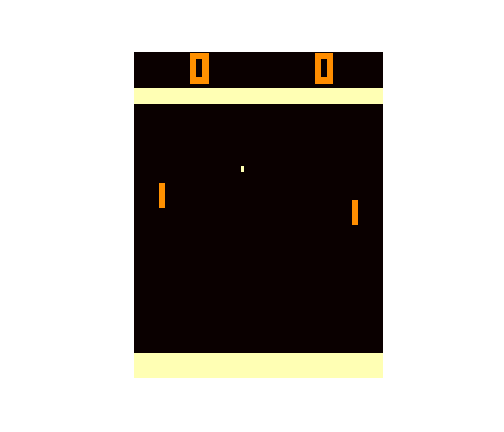
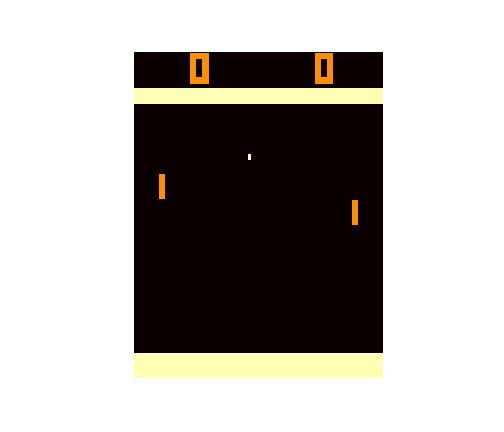
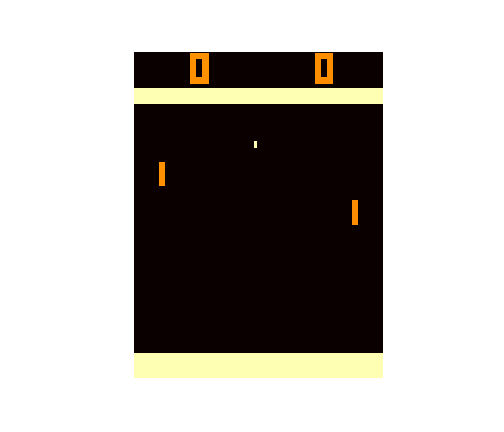
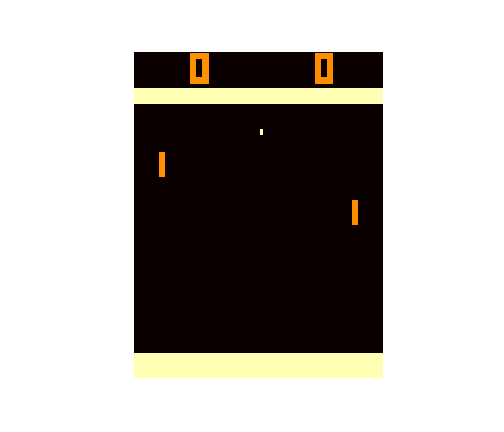
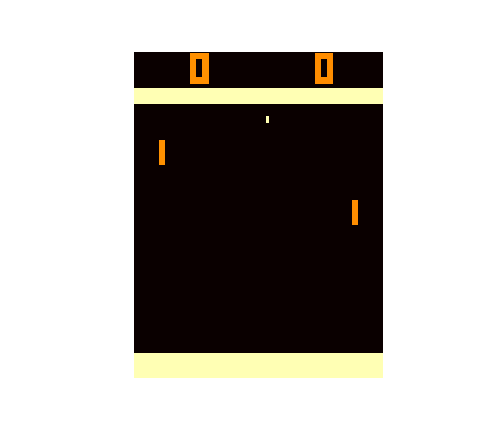
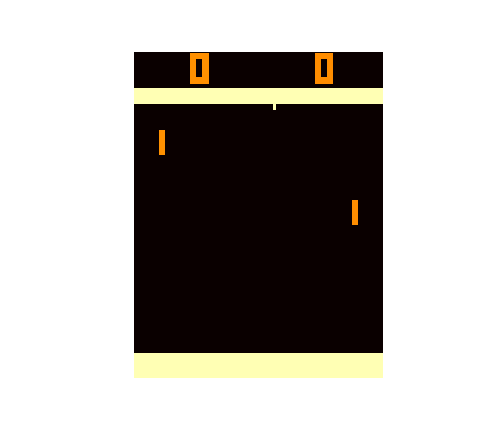
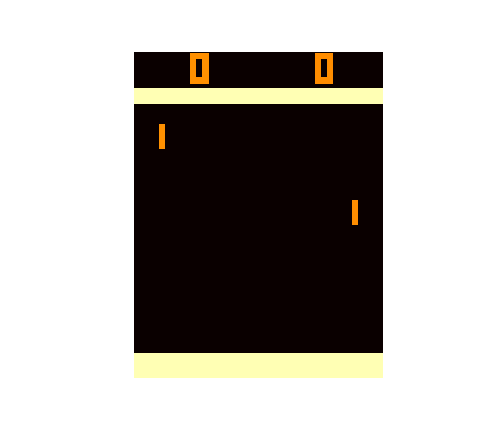
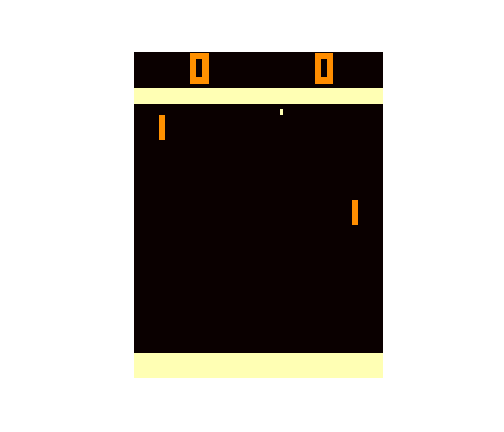
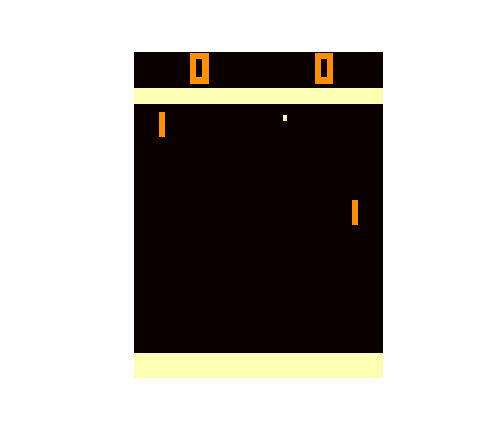
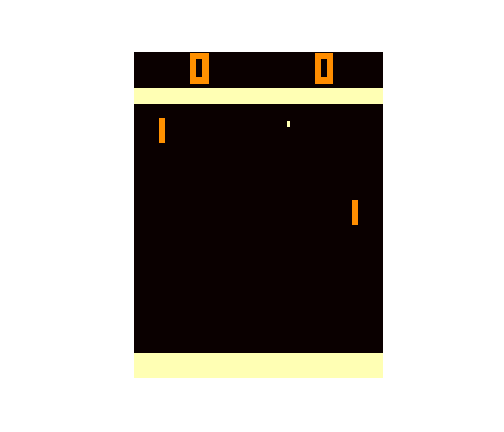
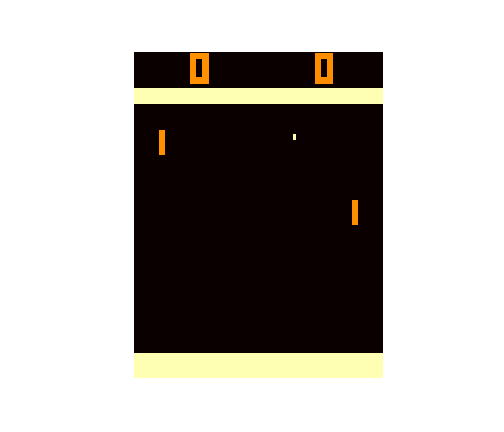
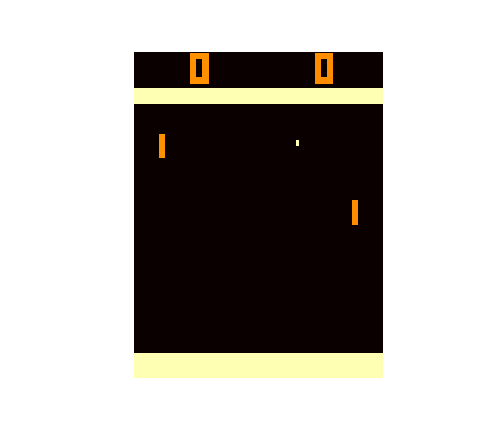
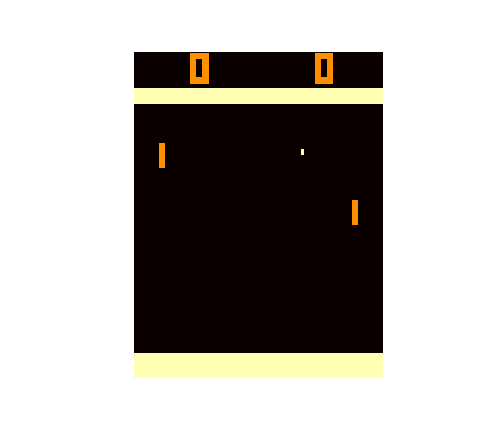
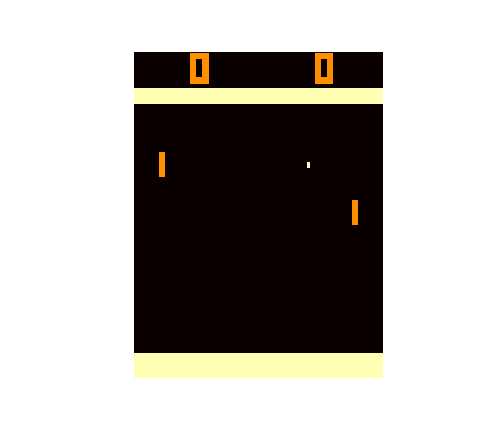
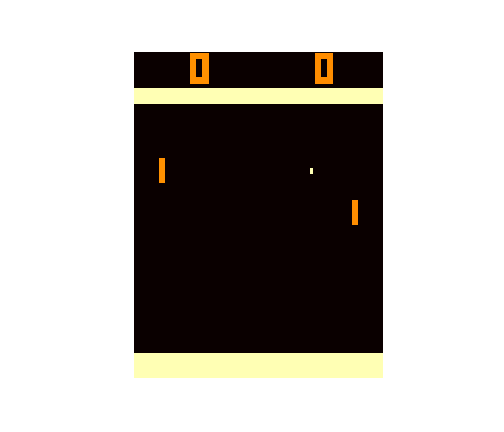
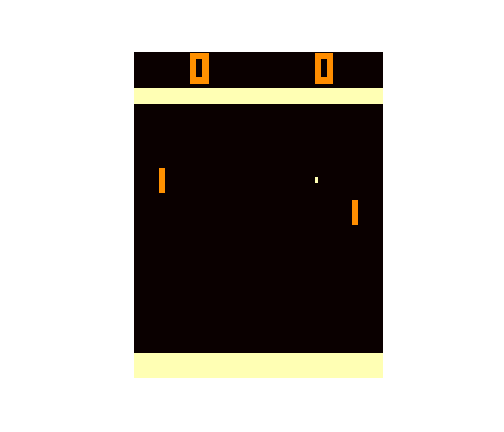
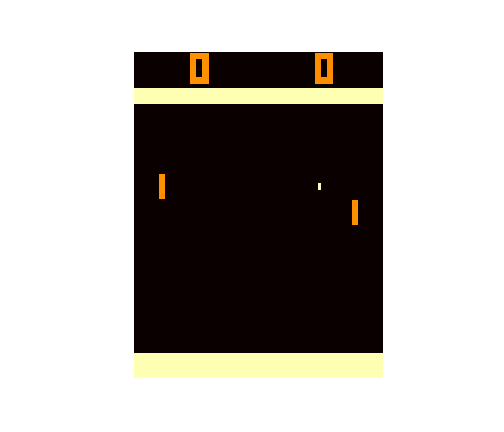
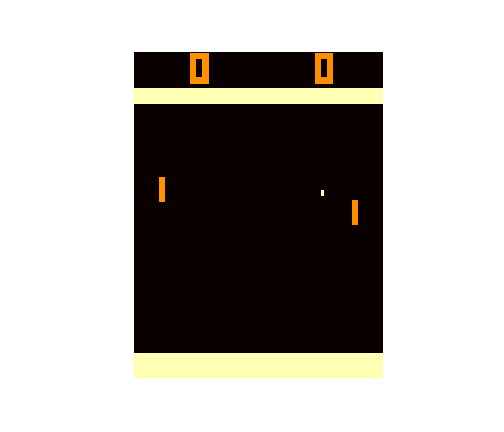
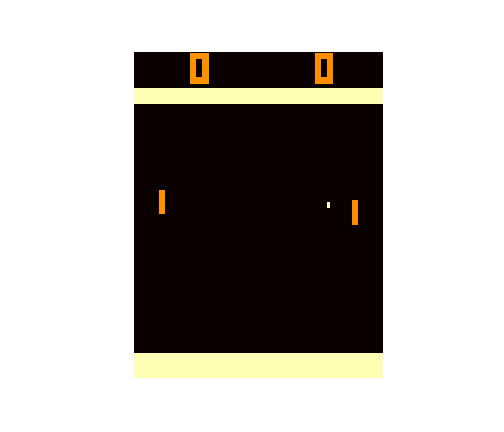
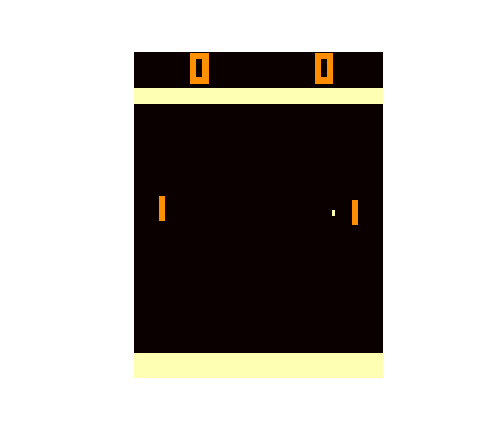
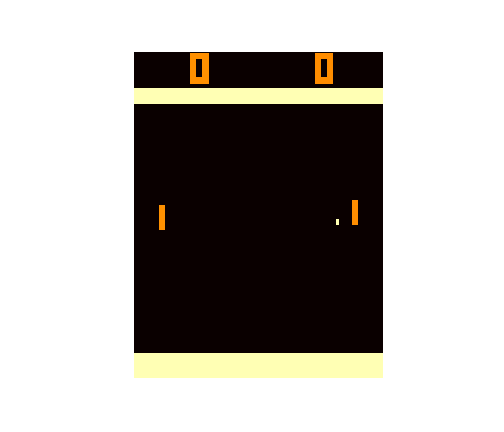
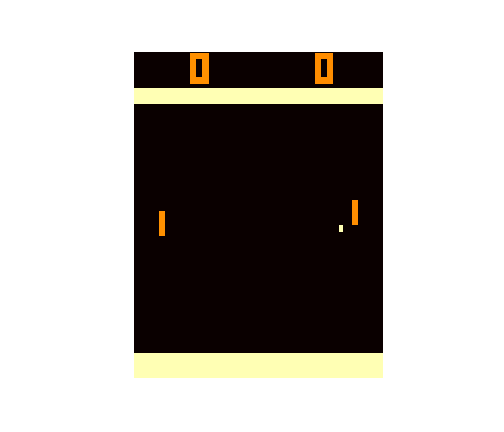
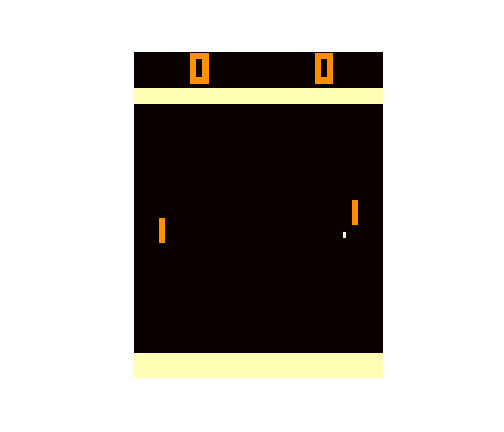
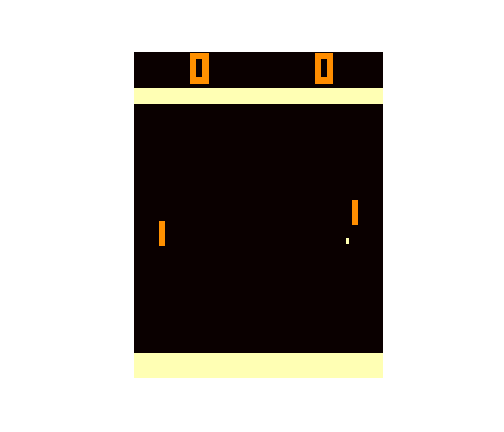
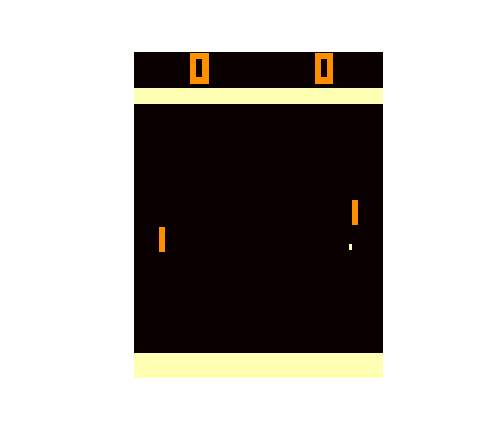
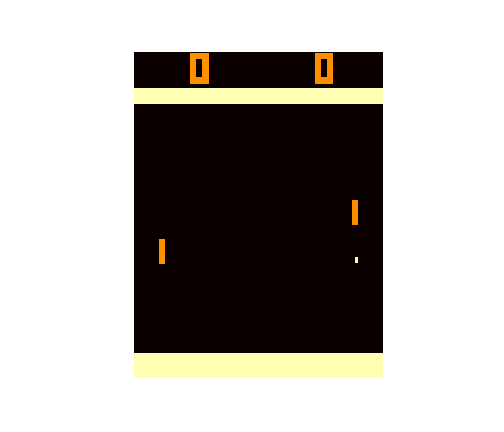
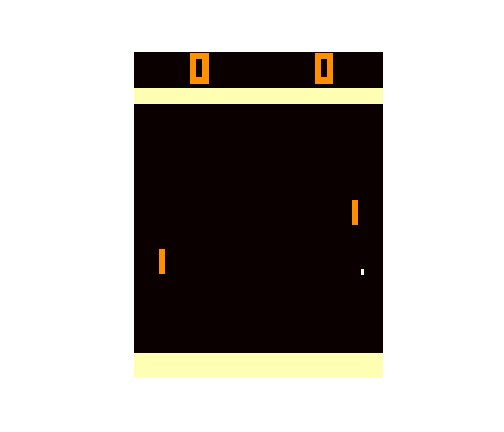
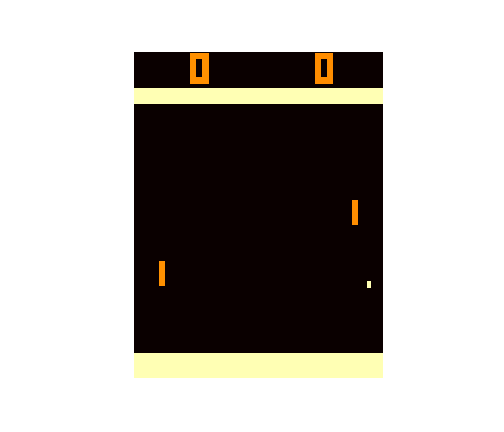
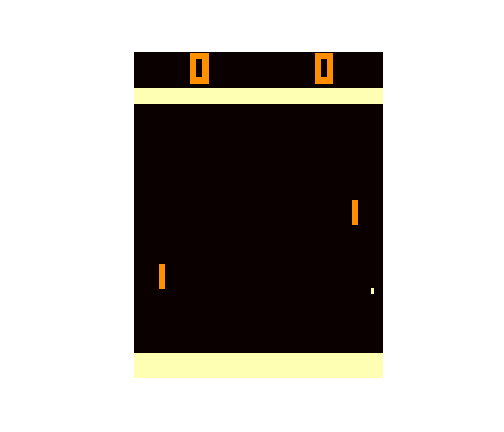
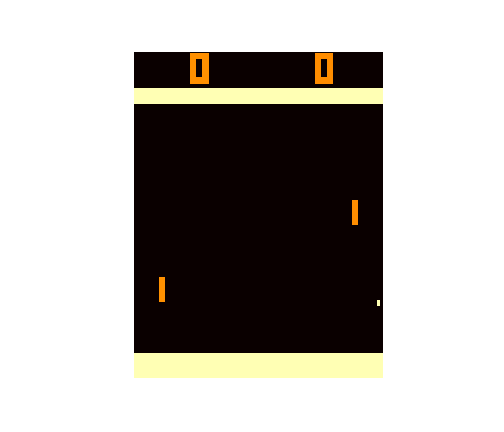
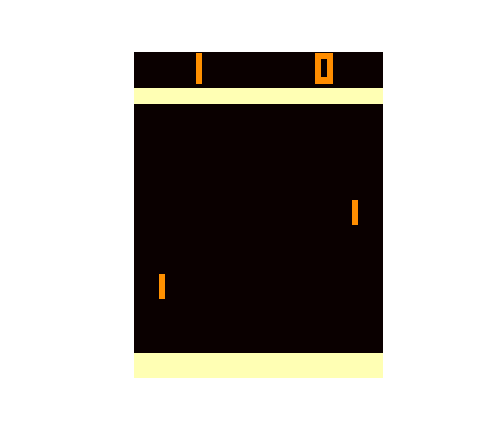
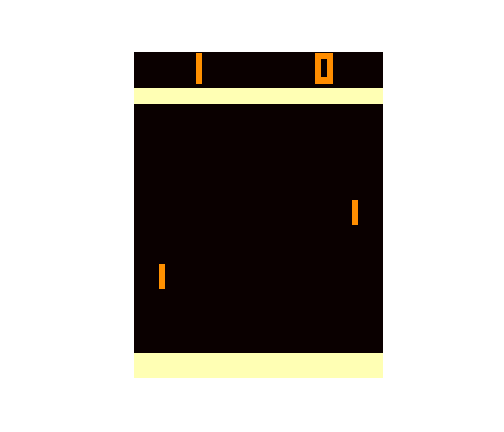
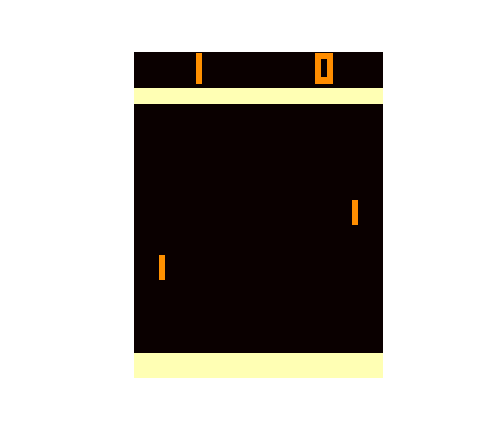
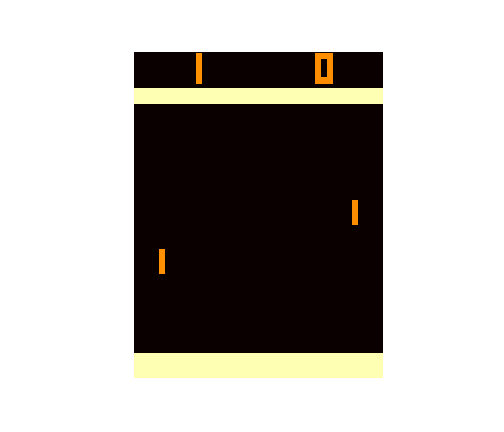
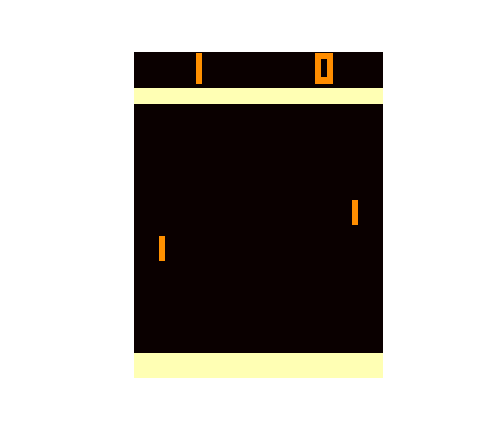
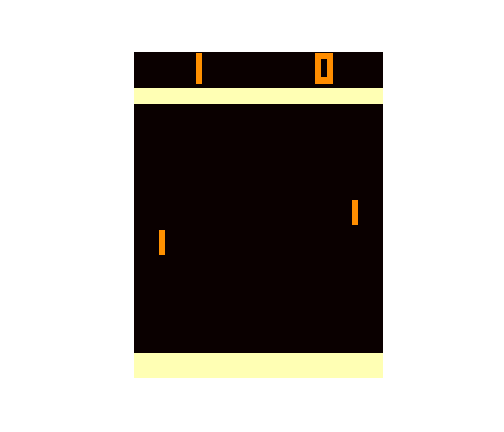
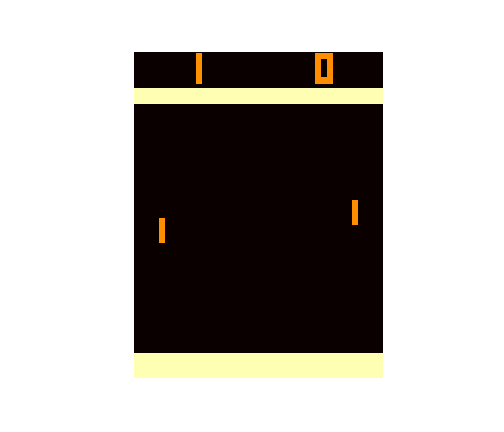
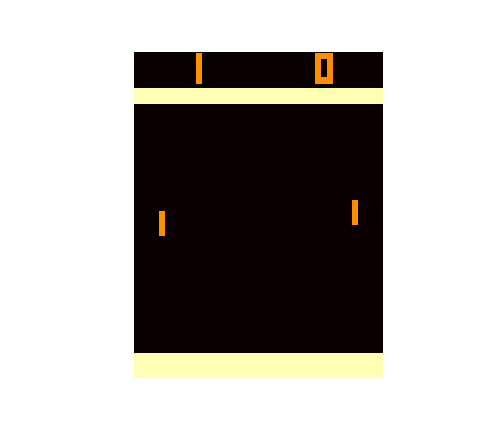
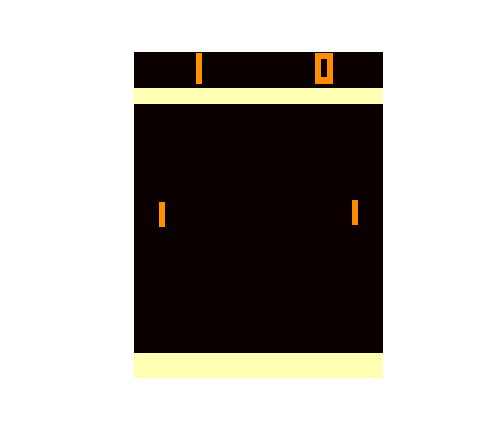
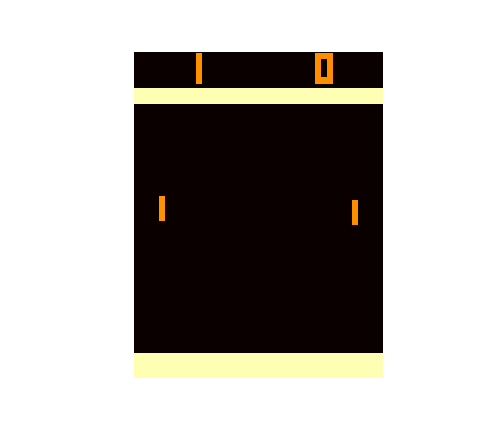
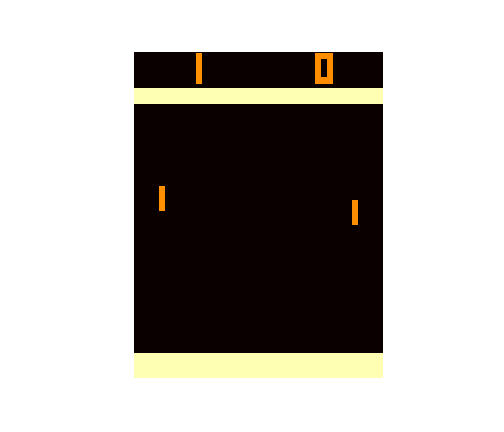
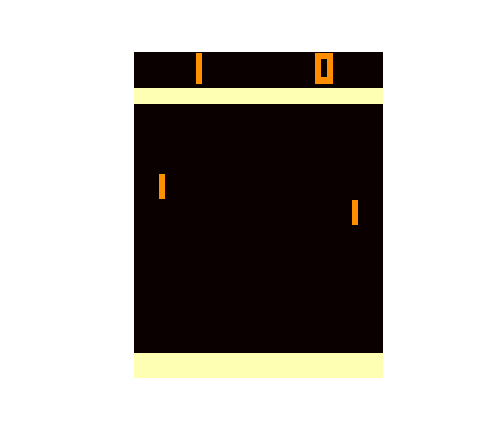
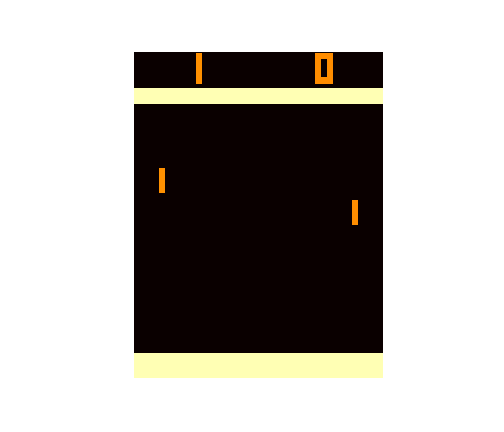
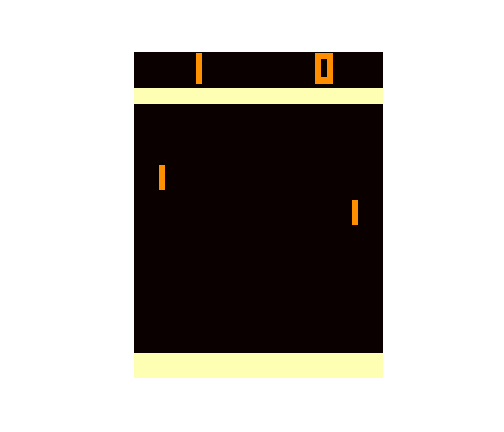

In [152]:
display_frames_as_gifB(frames)

In [153]:
# Params
max_volume = 400
max_distance = 30

In [154]:
# Find object clusters from diffs using contour detection
def clustersBoundsFromDiff(diff):
    _, gray = cv2.threshold(diff.copy(), 0, 255, cv2.THRESH_BINARY)
    gray, contours, hierarchy = cv2.findContours(gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    for cont in contours:
        box = cv2.boundingRect(cont) # [x,y,w,h]
        if box[2] * box[3] > max_volume: continue
        boxes.append(box)
        
    #find clusters
    centers = []
    clusters = []

    for box in boxes:
        found_center = False
        for i, center in enumerate(centers):
            x_diff = abs(center[0] - box[0])
            y_diff = abs(center[1] - box[1])
            if x_diff + y_diff < max_distance:
                found_center = True
                clusters[i].append(box)
                break
        if found_center == False:
            centers.append([box[0],box[1]])
            clusters.append([box])

    # x_min, y_min, x_max, y_max
    clusters_bounds = []
    for cluster in clusters:
        # Goal:   x_min, y_min, x_max, y_max
        bounds = [999,   999,   0,     0]
        for item in cluster:
            item_bounds = [item[0], item[1], item[0]+item[2], item[1] + item[3]]
            if item_bounds[0] < bounds[0]: bounds[0] = item_bounds[0]
            if item_bounds[1] < bounds[1]: bounds[1] = item_bounds[1]
            if item_bounds[2] > bounds[2]: bounds[2] = item_bounds[2]
            if item_bounds[3] > bounds[3]: bounds[3] = item_bounds[3]
        clusters_bounds.append(bounds)
    return clusters_bounds


In [155]:
cluster_list = []
for diff in diffs:
    cluster_list.append(clustersBoundsFromDiff(diff))

In [156]:
# display_frames_as_gifB(frames, cluster_list, 3)

In [157]:
# Find full-frame-relative location for object in a cluster
def trueLocation(x,y, cluster):
    true_x = cluster[0] + x
    true_y = cluster[1] + y
    return true_x, true_y

# Returns objects 
def objectsFromClustersBounds(clusters_bounds, frame):
    found_objects = []
    for cluster in clusters_bounds:
         # extract region of interest from frame
        interest = frame[cluster[1]:cluster[3]]
        interest = [line[cluster[0]:cluster[2]] for line in interest]
        interest = np.asarray(interest)
        ishape = interest.shape
        # See if existing objects are found
        for j, obj in enumerate(object_templates):
            if ishape[0] < obj.shape[0] or ishape[1] < obj.shape[1]: continue
            result = cv2.matchTemplate(interest,obj, cv2.TM_SQDIFF_NORMED)
            minVal,maxVal,minLoc,maxLoc = cv2.minMaxLoc(result)
            if minVal < 0.0001:
                x,y = trueLocation(minLoc[0], minLoc[1], cluster)
                found_objects.append([j, (x,y)])
        
        # Detect new objects
        gray2, contours, hierarchy = cv2.findContours(interest.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        for cont in contours:
            x,y,w,h = cv2.boundingRect(cont)
            
            # Check for overlap, 
            x_t, y_t = trueLocation(x, y, cluster)
            overlap = False
            for ob in found_objects:
                if x_t == ob[1][0] and y_t == ob[1][1]:
                    overlap = True
                    break 
            if overlap == True:
                continue # Skip redundant objects overlapping at exact x,y

            h2 = y+h 
            w2 = x+w
            obj = interest[y:h2]
            obj = [line[x:w2] for line in obj]
            obj = np.asarray(obj)
            exists = False
            for existing in object_templates:
                if np.array_equal(existing,obj):
                    exists = True
                    break
            if exists == False:
                x, y = trueLocation(x, y, cluster)
                found_objects.append([len(object_templates), (x,y)])
                object_templates.append(obj) #TODO: Replace global var!
    return found_objects

In [158]:
# Generate object history and list of objects
object_history = [] # Per frame history of objects observed
object_templates = [] # Pixel templates for each unique object
for i in range(len(frames)-1): #skip last frame to prevent out-of-bounds
    obs = objectsFromClustersBounds(cluster_list[i], frames[i+1])
    object_history.append(obs)
print(len(object_templates))

7


In [218]:
print(frames[5].shape)

(210, 160)


In [159]:
for i, obs in enumerate(object_templates):
    print(i)
    print(obs)

0
[[148 148]
 [148 148]
 [148 148]
 [148 148]
 [148 148]
 [148 148]
 [148 148]
 [148 148]
 [148 148]
 [148 148]
 [148 148]
 [148 148]
 [148 148]
 [148 148]]
1
[[148 148]
 [148 148]
 [148 148]
 [148 148]
 [148 148]
 [148 148]
 [148 148]
 [148 148]
 [148 148]
 [148 148]
 [148 148]
 [148 148]
 [148 148]
 [148 148]
 [148 148]]
2
[[236]
 [236]
 [236]]
3
[[148 148 148]
 [148 148 148]
 [148 148 148]
 [148 148 148]
 [148 148 148]
 [148 148 148]
 [148 148 148]
 [148 148 148]
 [148 148 148]
 [148 148 148]
 [148 148 148]
 [148 148 148]
 [148 148 148]
 [148 148 148]
 [148 148 148]]
4
[[148 148 148 236 236]
 [148 148 148 236 236]
 [148 148 148 236 236]
 [148 148 148 236 236]
 [148 148 148   0   0]
 [148 148 148   0   0]
 [148 148 148   0   0]
 [148 148 148   0   0]
 [148 148 148   0   0]
 [148 148 148   0   0]
 [148 148 148   0   0]
 [148 148 148   0   0]
 [148 148 148   0   0]
 [148 148 148   0   0]
 [148 148 148   0   0]]
5
[[148 148 148]
 [148 148 148]
 [148 148 148]
 [148 148 148]
 [148 148 148

In [160]:
# Generate image segmentation overlay for debugging/visualization
color_map = {"0":"c", "1":"g", "2":"r", "3":"w", "4":"m", "5":"y", "6":"b"}
rects = []
for obs in object_history:
    #obs: [num, [x,y]]
    #cluster: xmin, ymin, xmax, ymax, color
    #object: 2d array
    rectangles = []
    for ob in obs:
        num = ob[0]
        if num != 0 and num !=2: continue
        x,y = ob[1][0], ob[1][1]
        color = color_map.get(str(num%6))
        if color is None:
            color = "w"
        obj_shape = object_templates[num].shape
        cluster = [x,y,x+obj_shape[1],y+obj_shape[0], color]
        rectangles.append(cluster)
    rects.append(rectangles)

Loading 99 frames... 19%38%57%76%95%


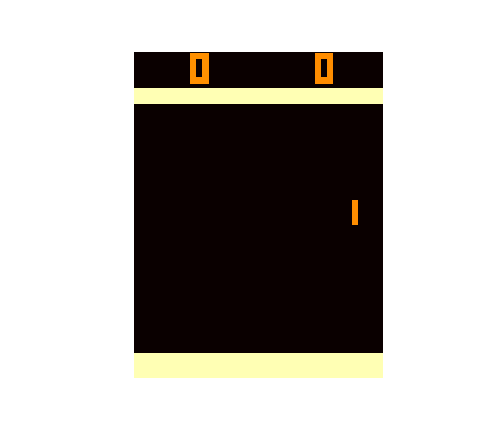
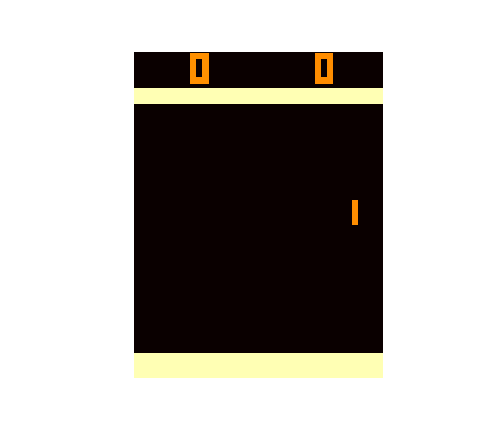
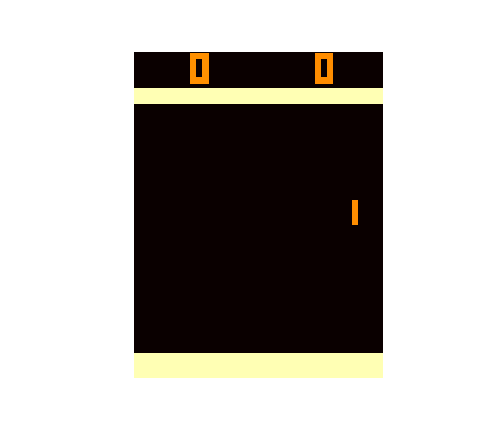
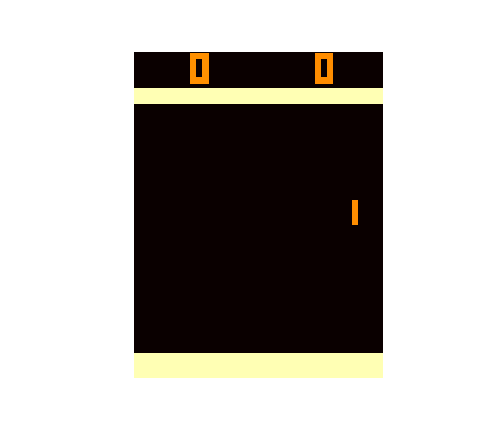
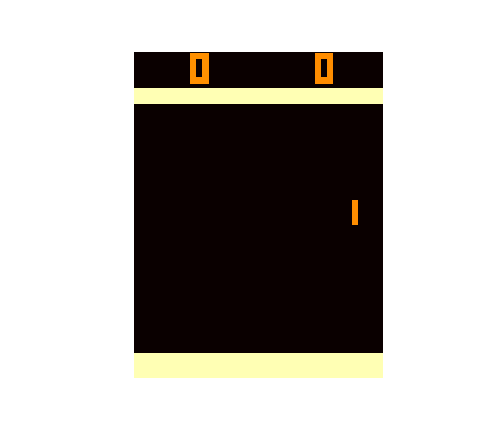
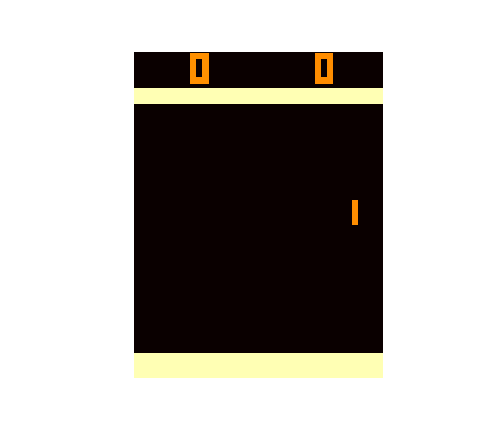
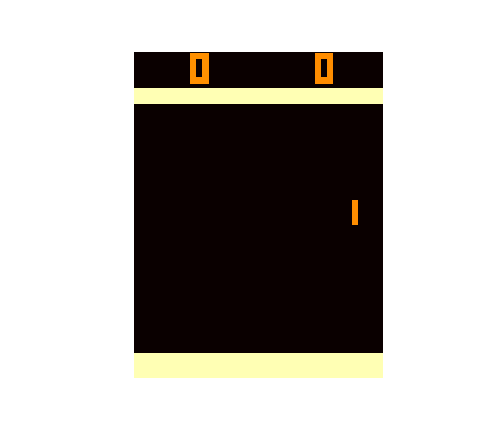
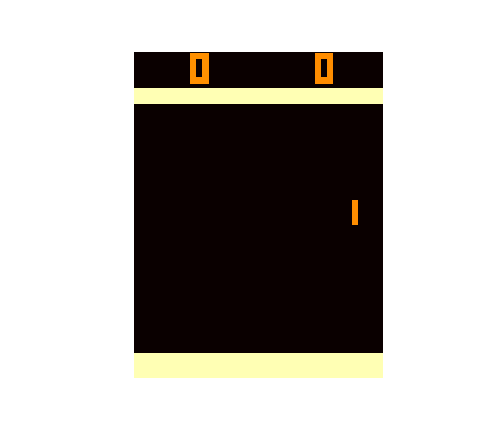
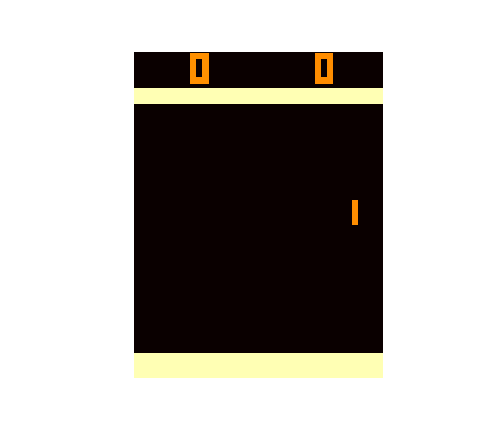
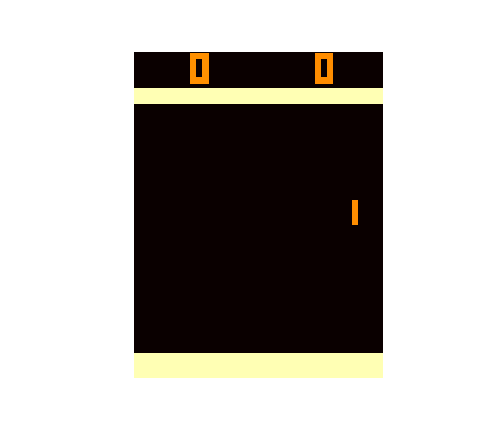
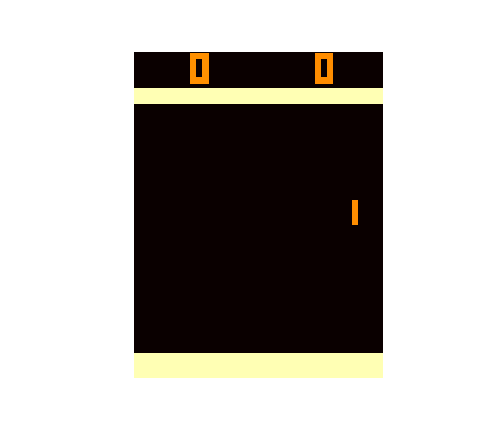
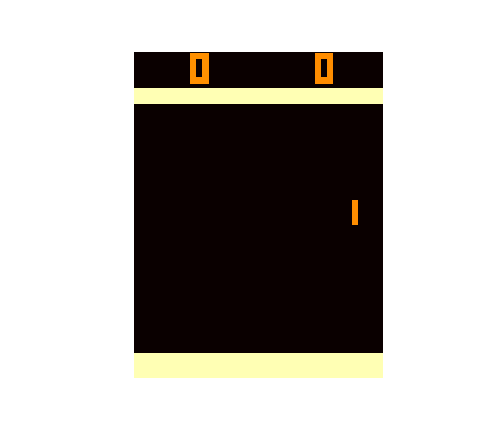
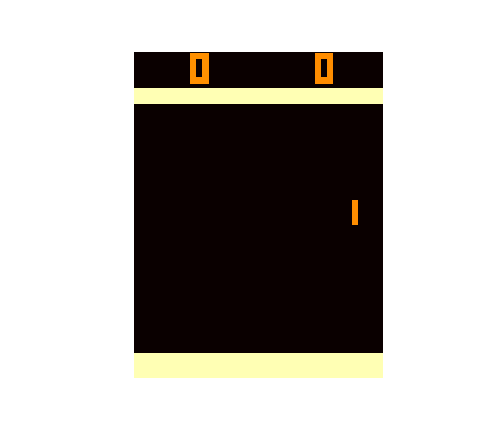
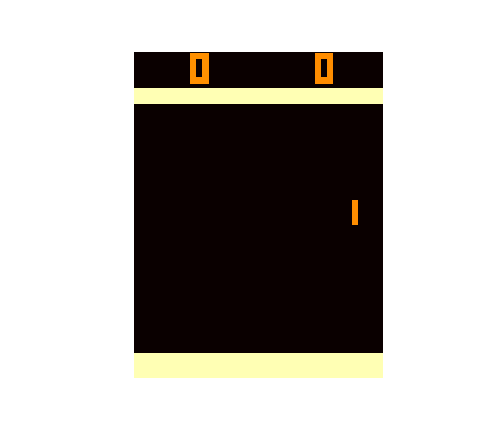
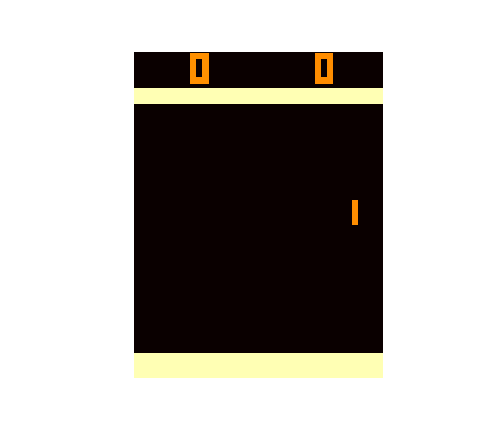
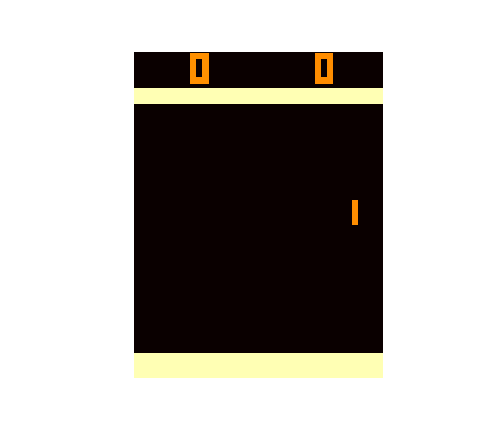
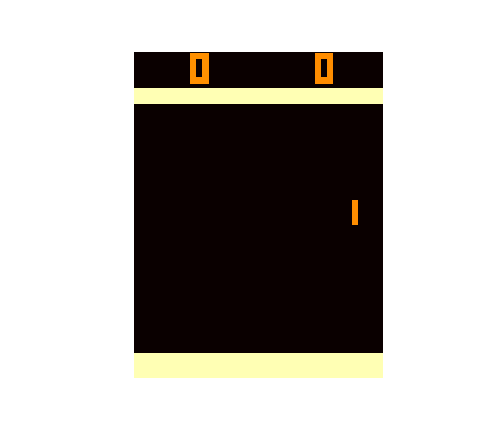
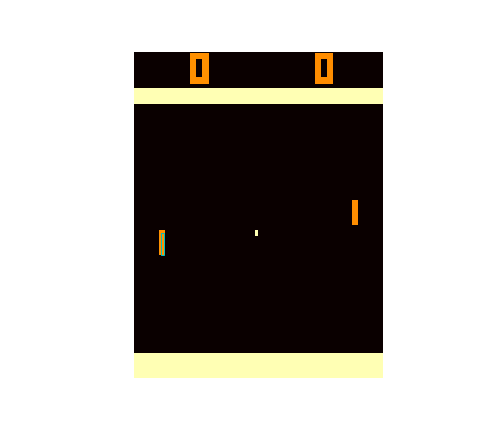
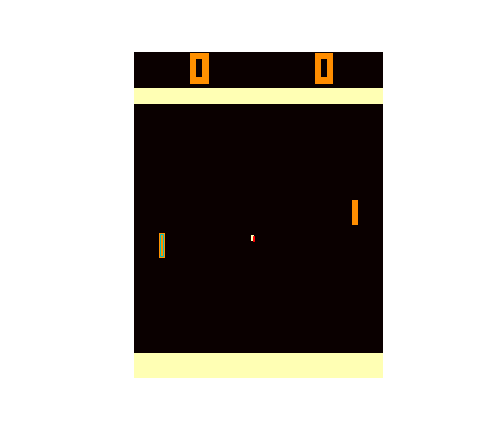
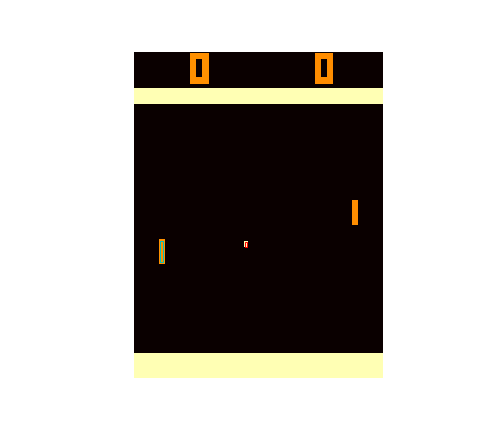
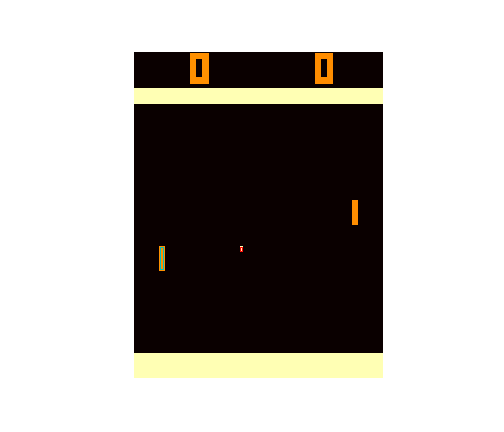
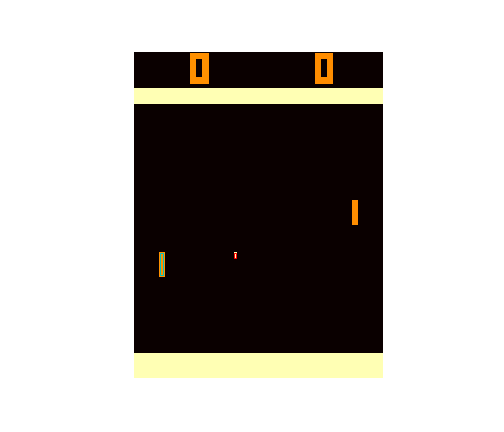
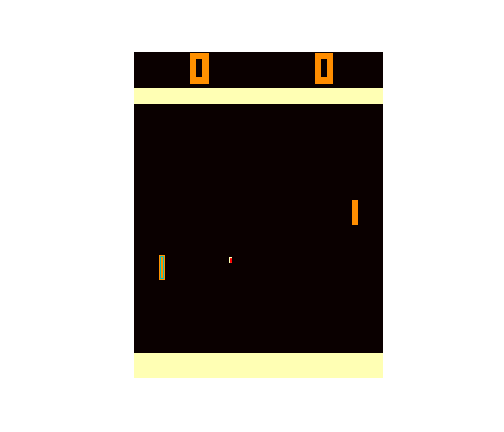
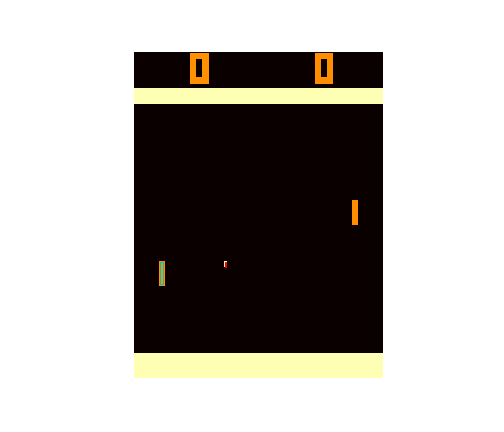
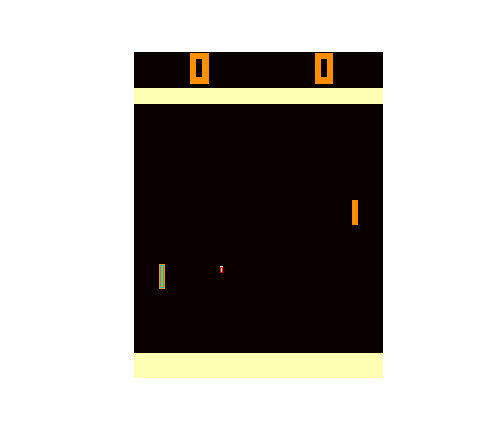
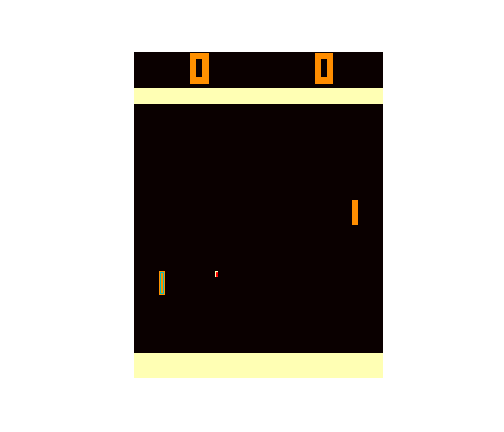
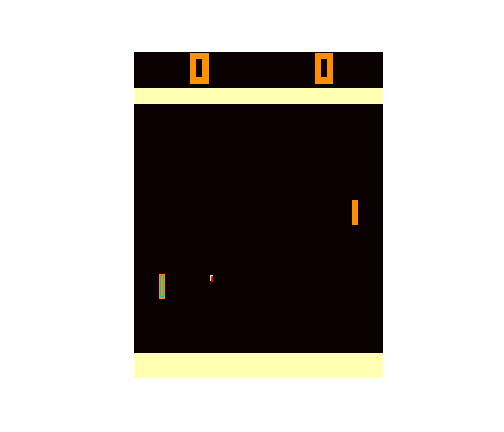
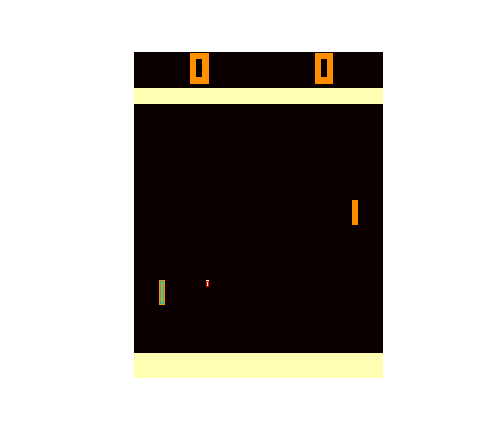
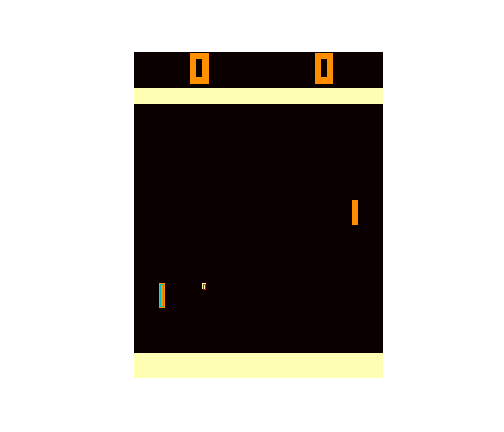
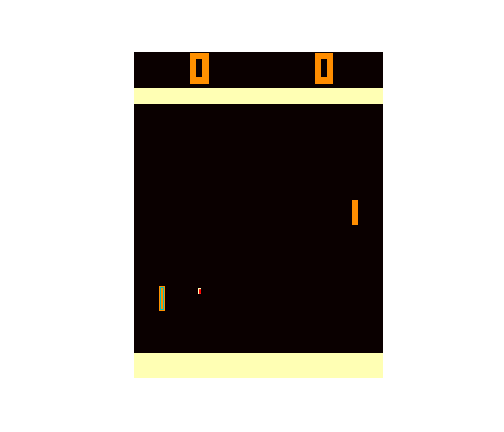
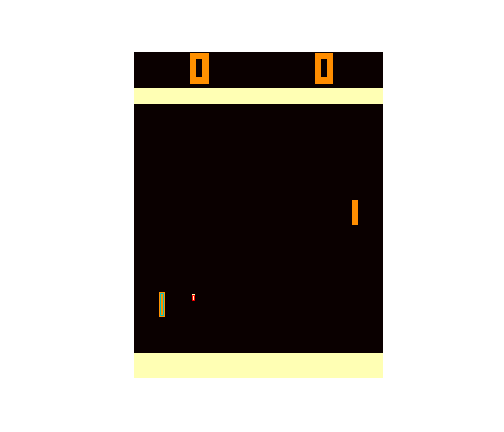
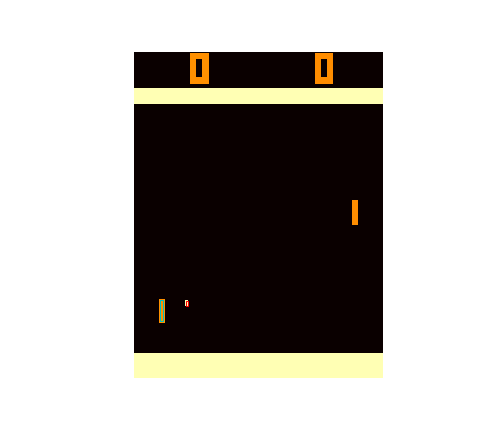
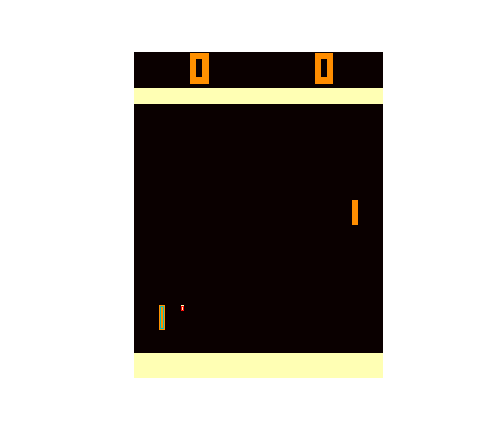
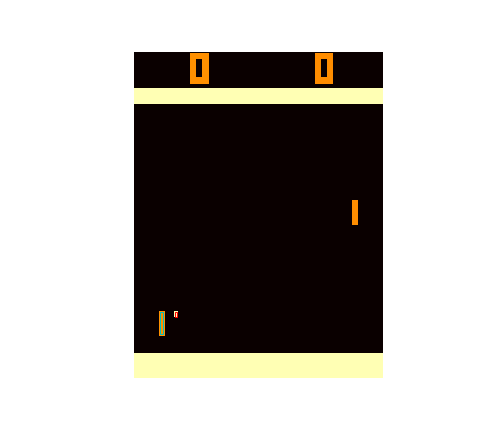
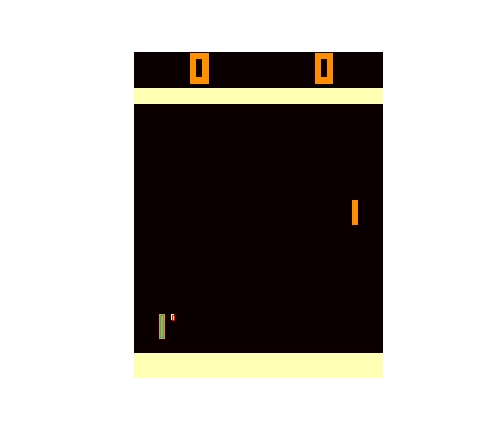
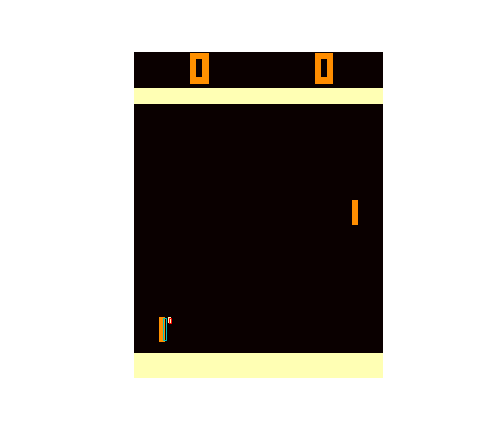
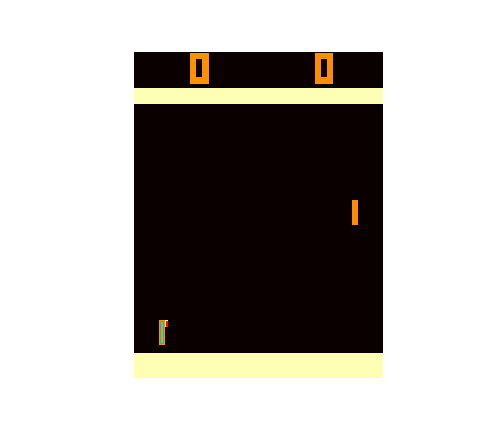
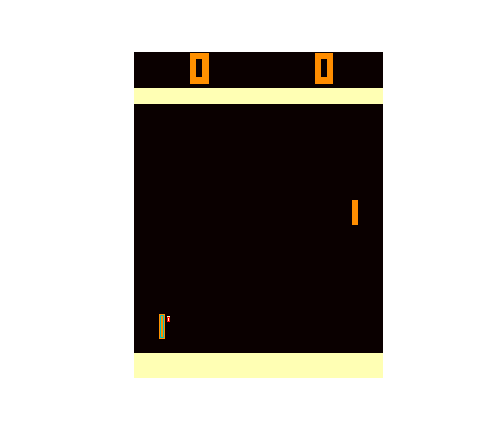
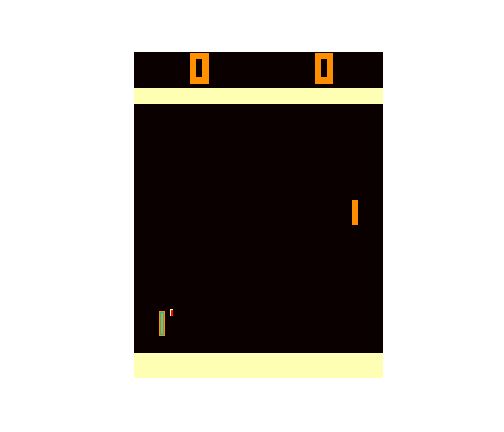
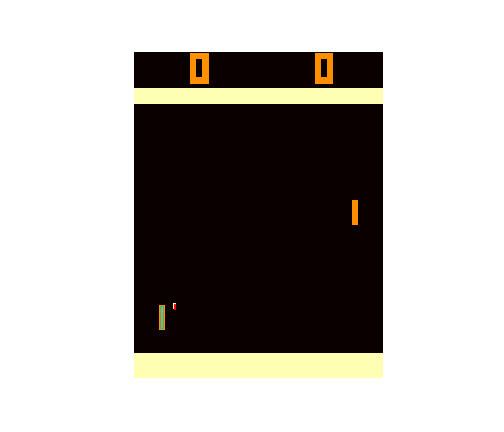
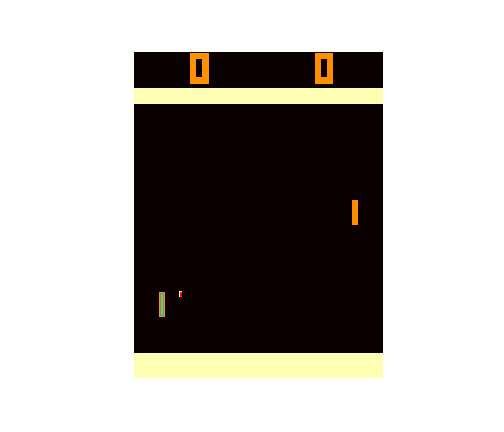
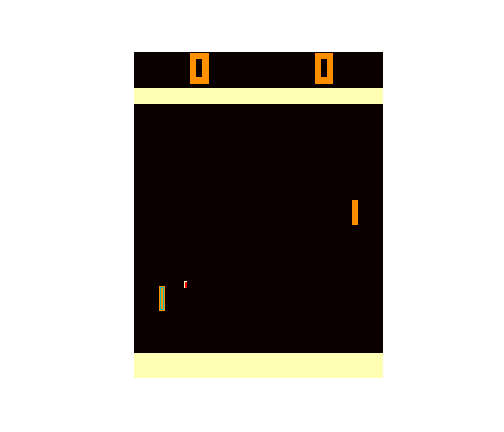
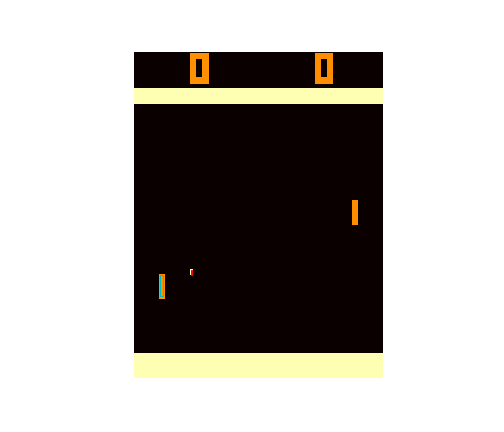
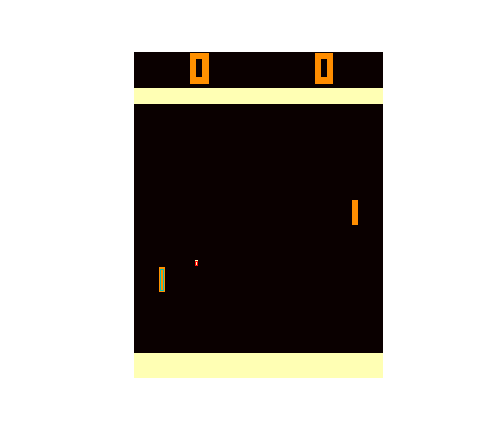
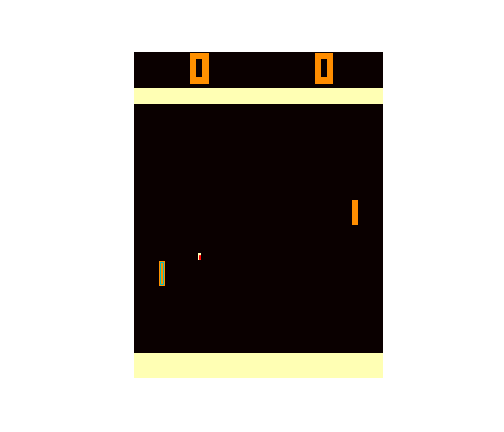
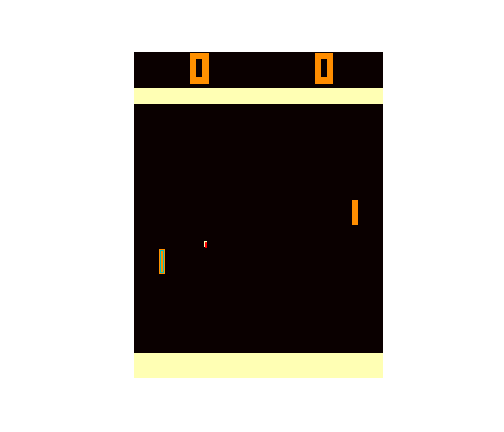
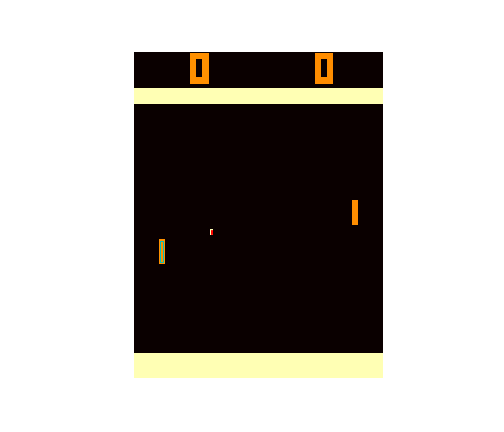
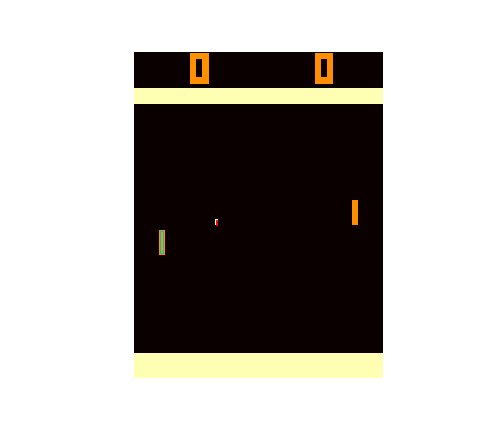
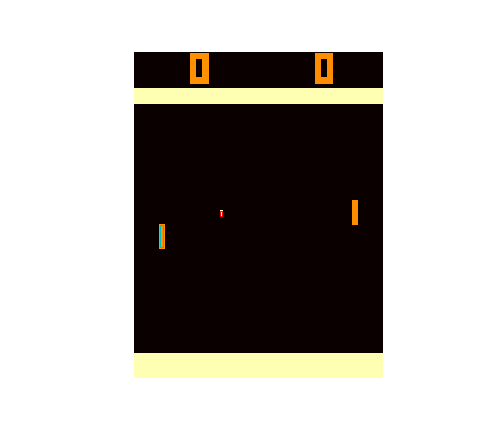
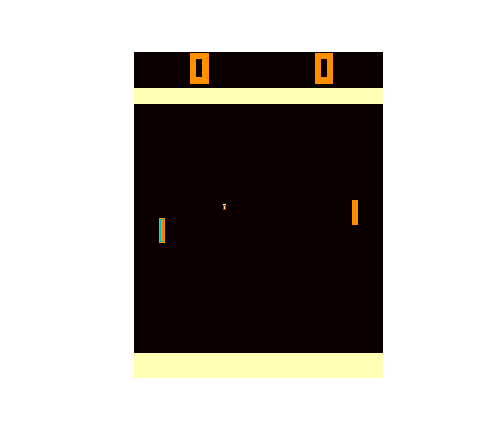
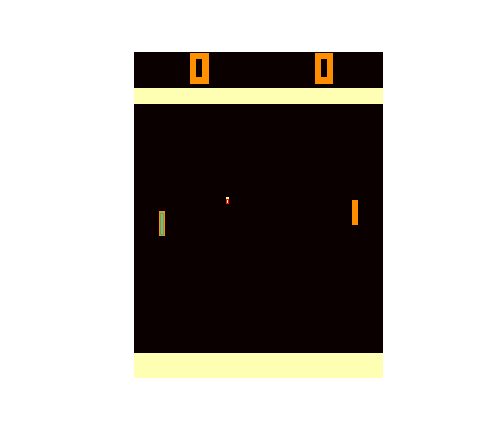
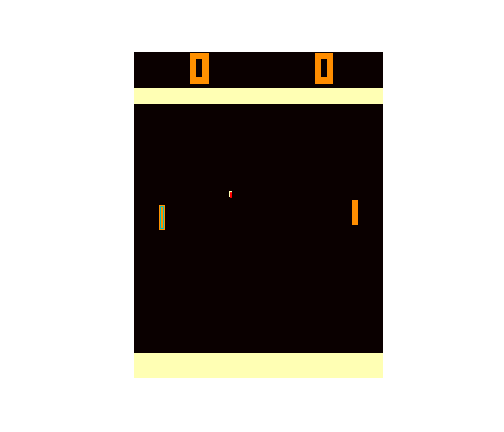
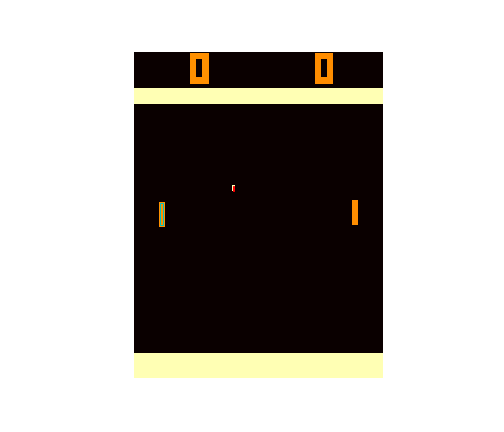
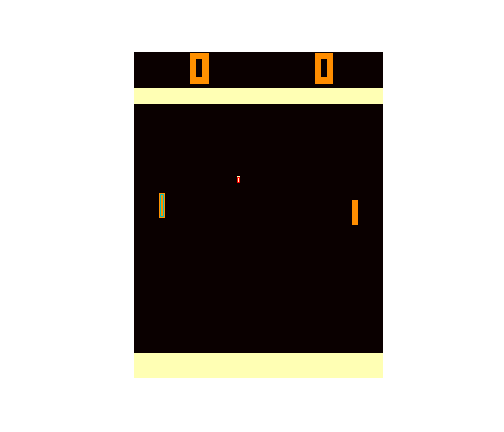
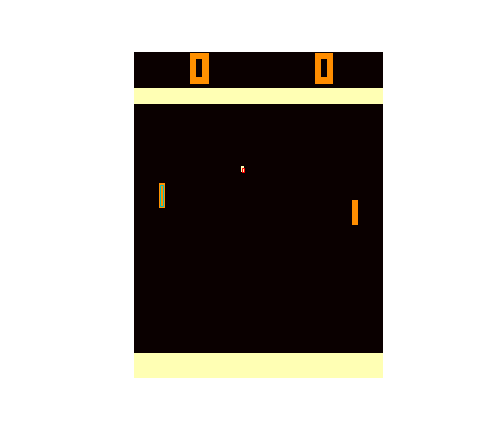
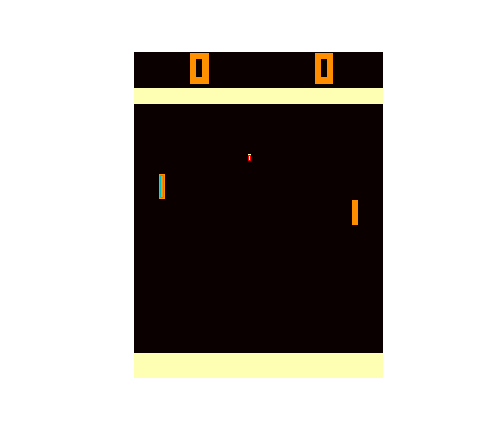
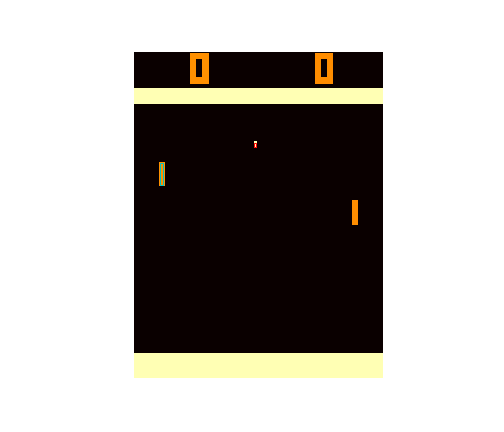
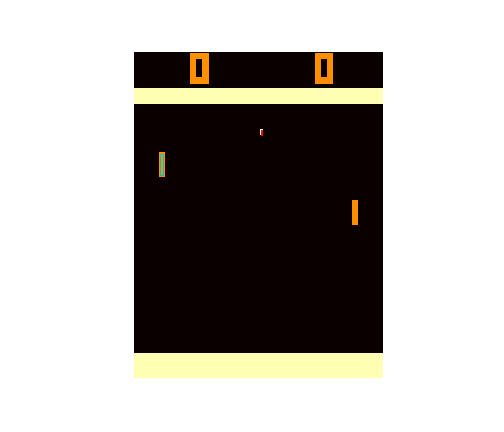
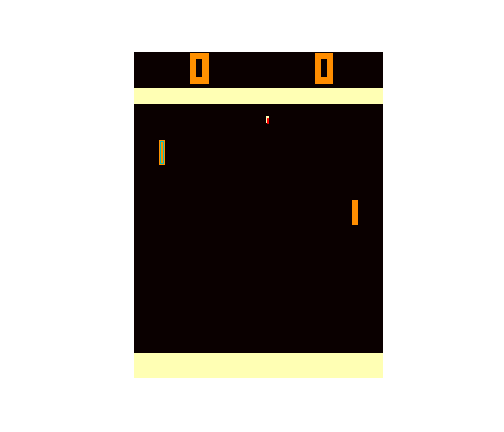
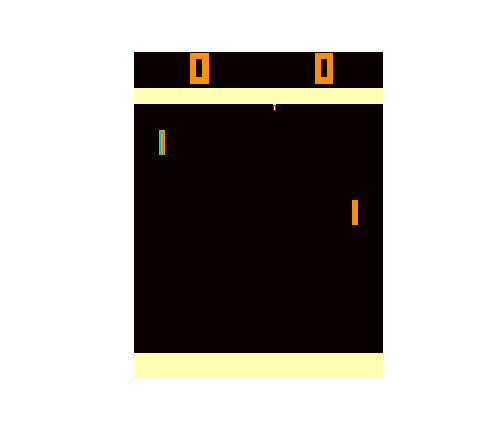
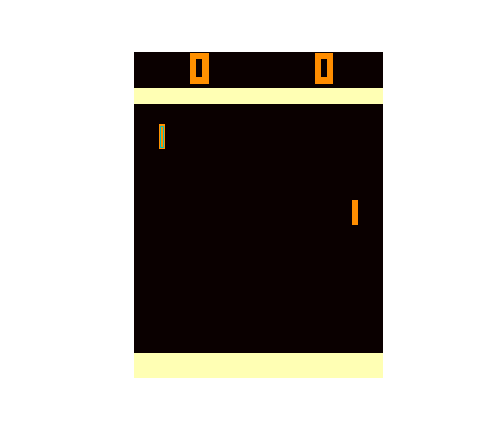
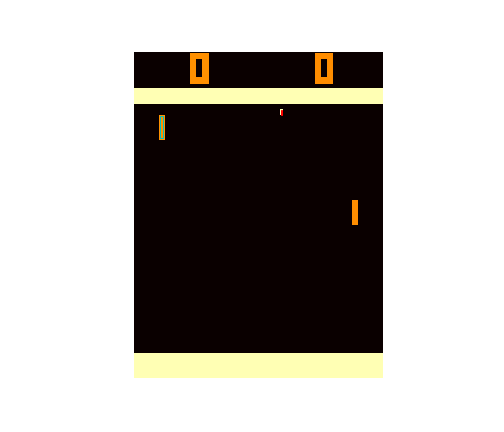
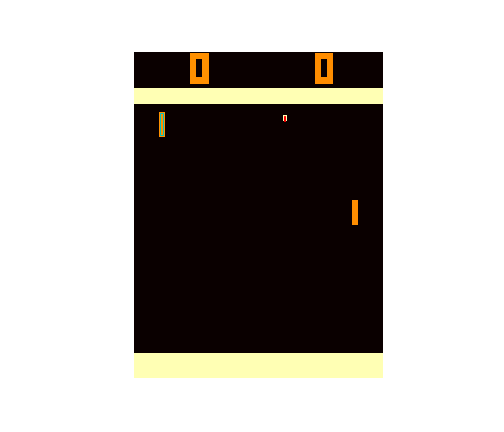
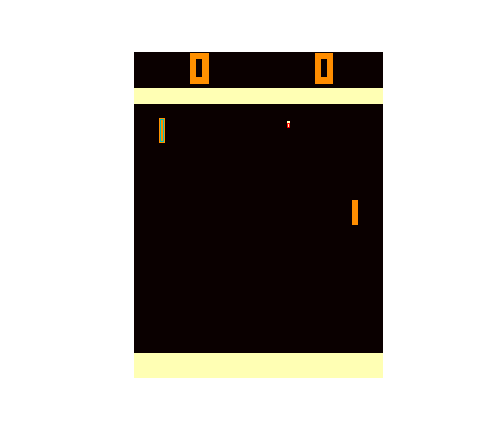
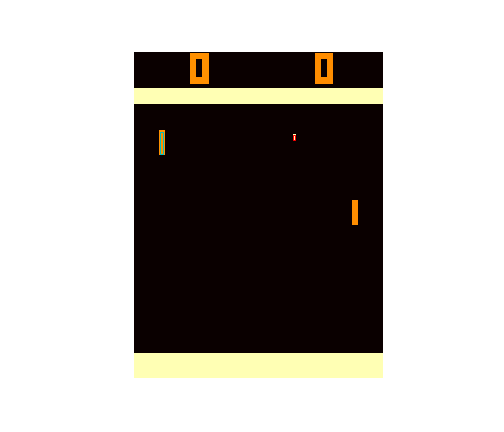
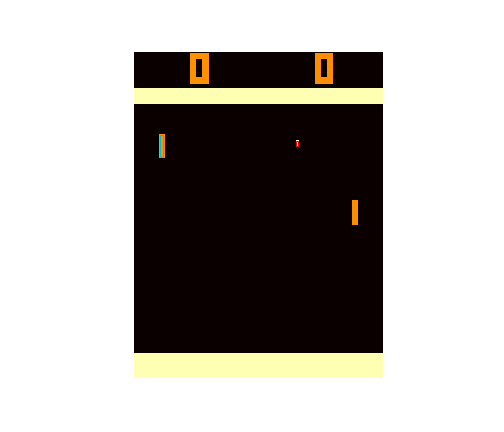
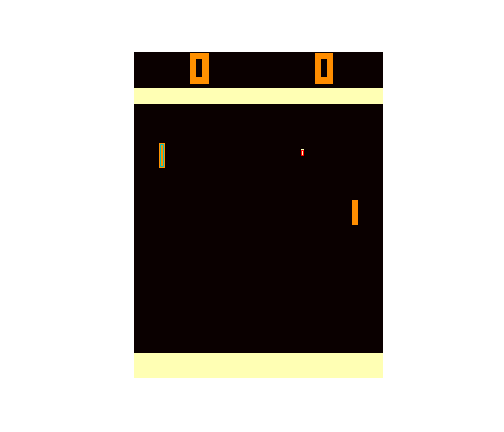
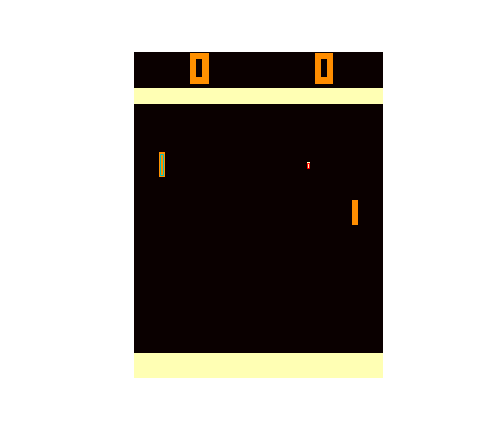
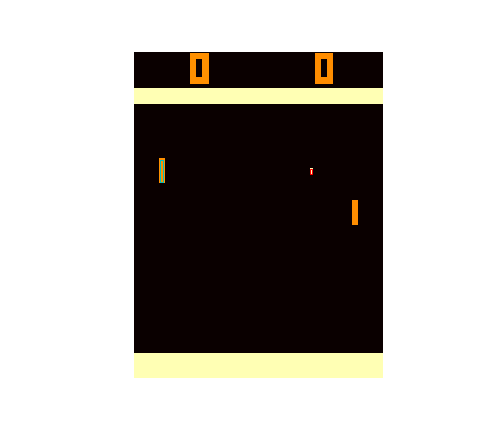
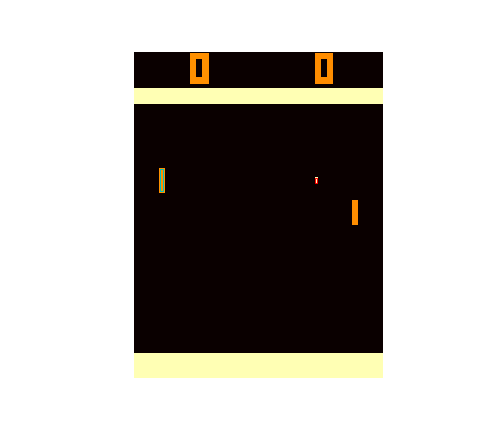
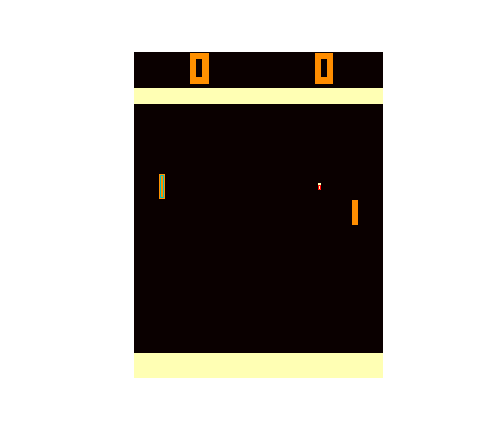
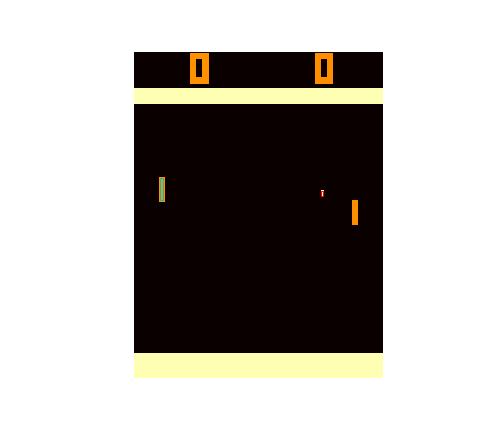
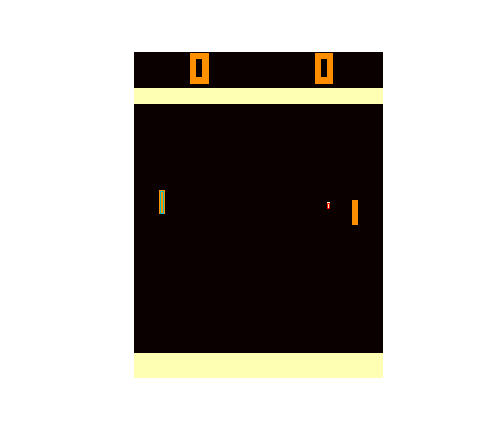
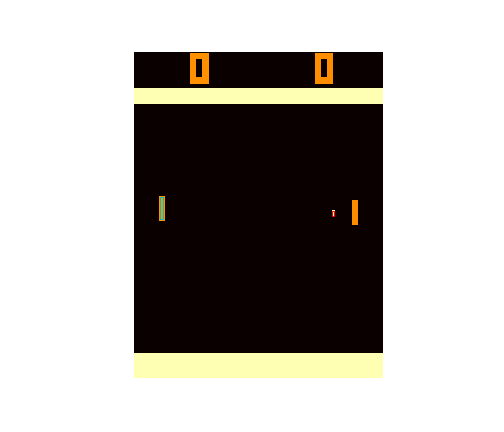
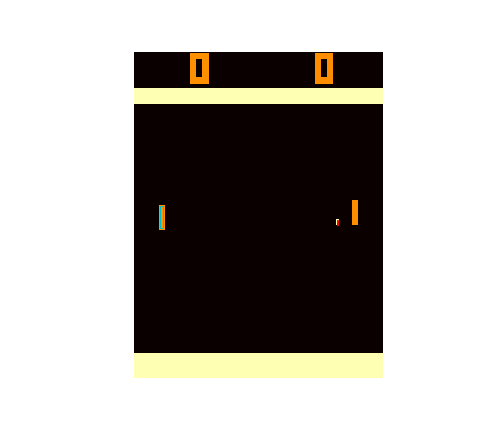
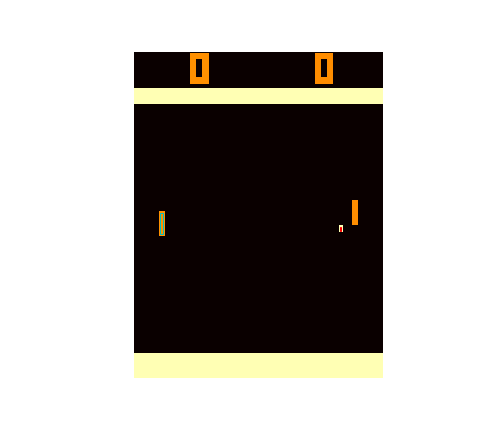
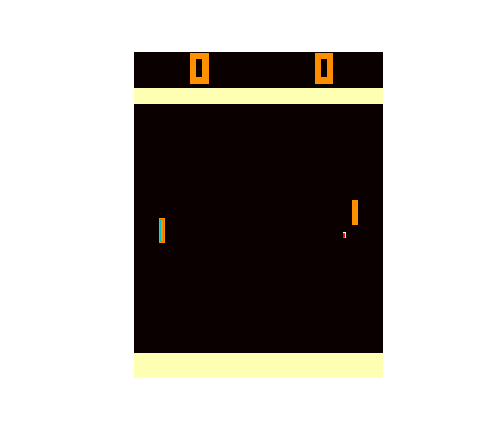
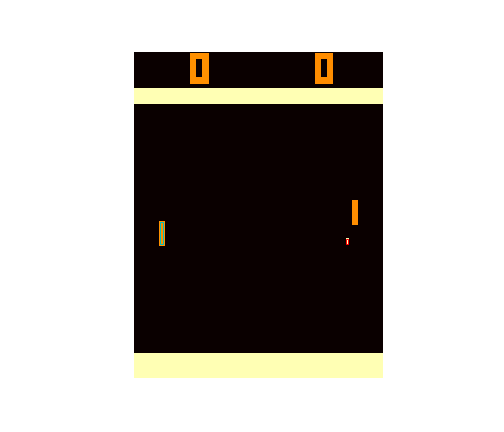
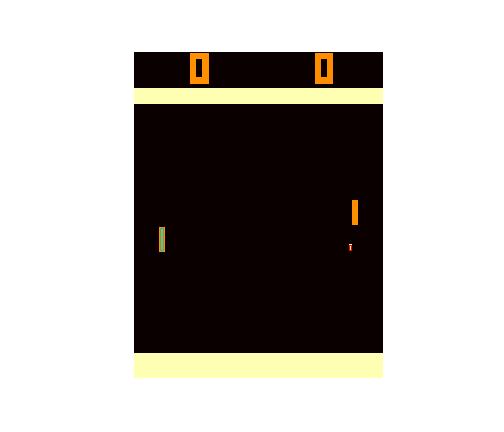
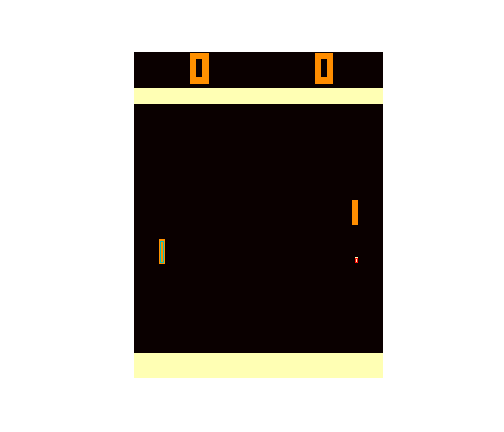
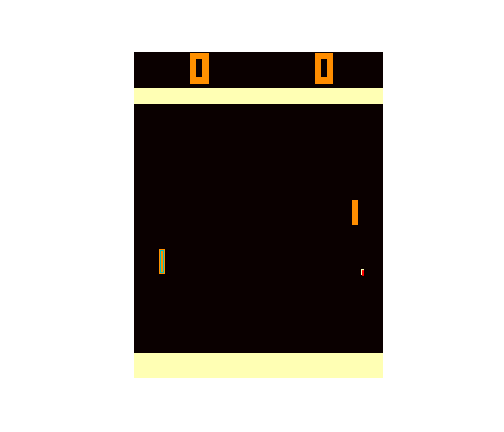
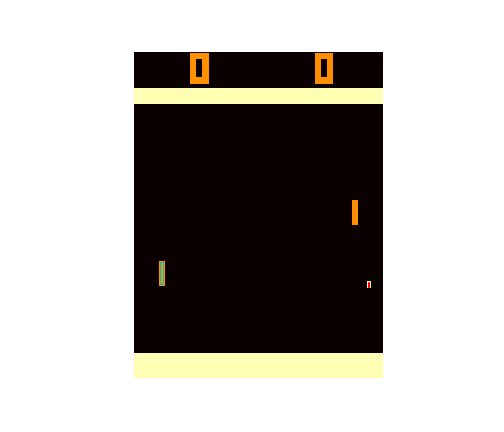
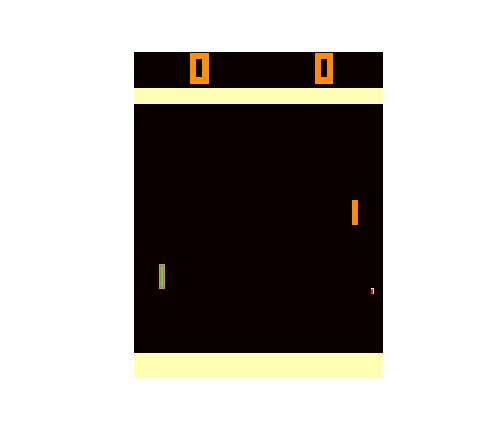
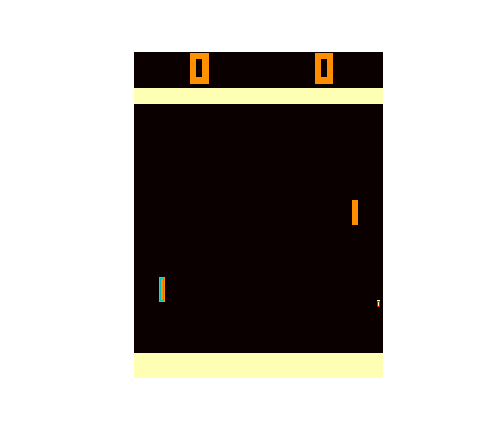
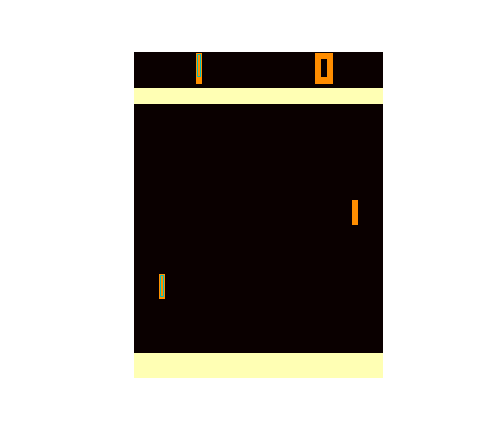
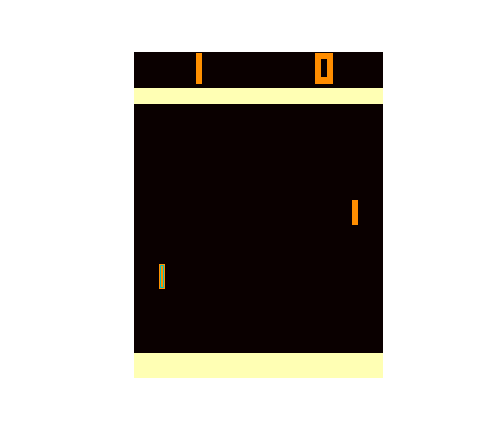
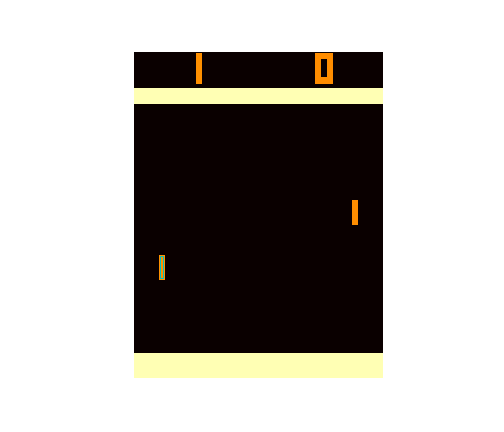
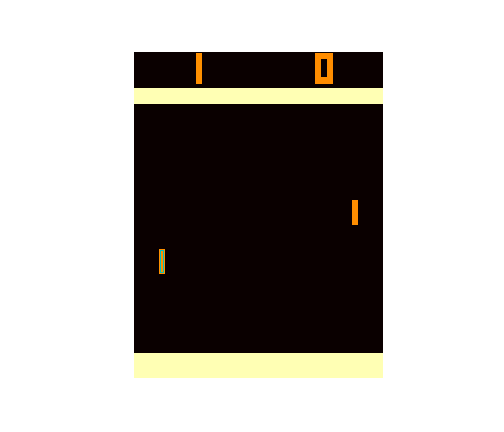
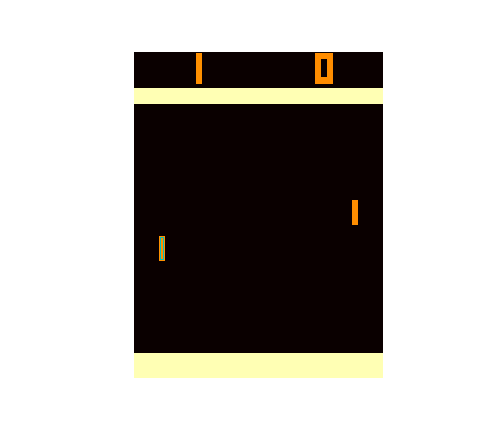
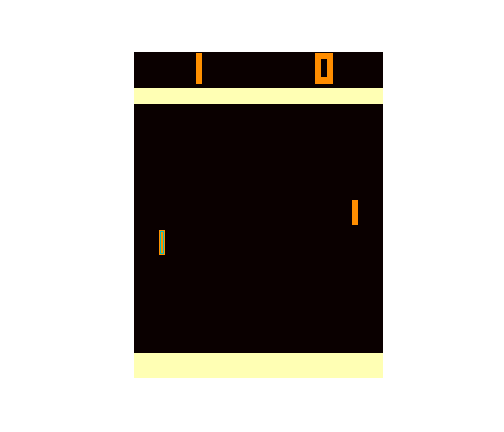
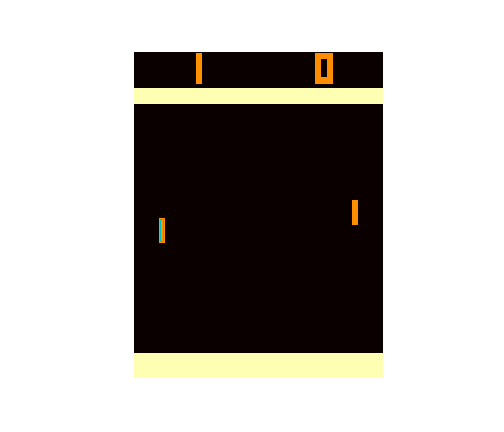
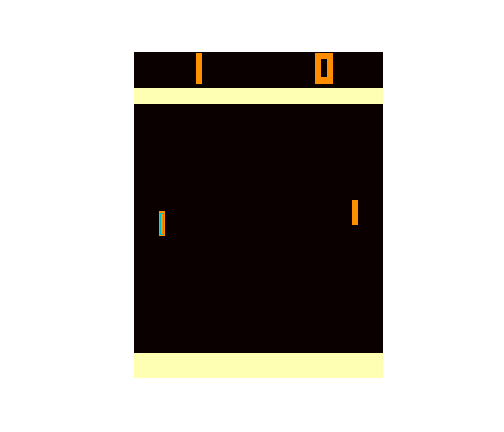
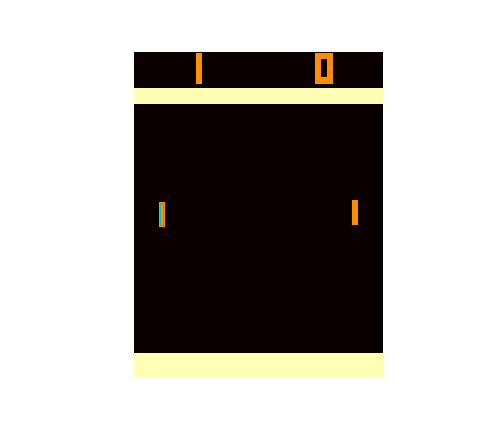
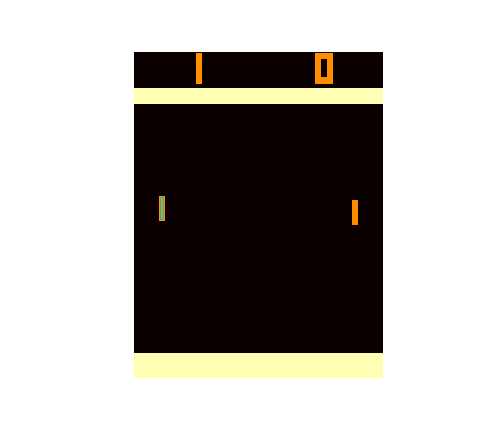
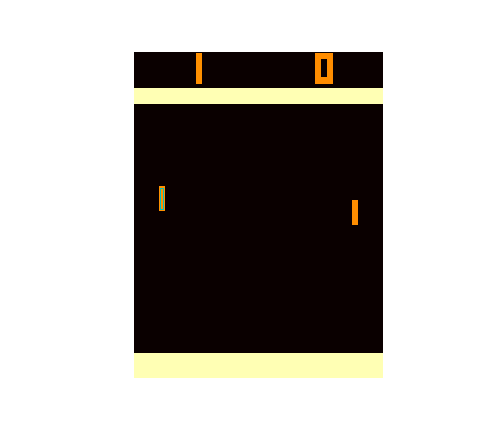
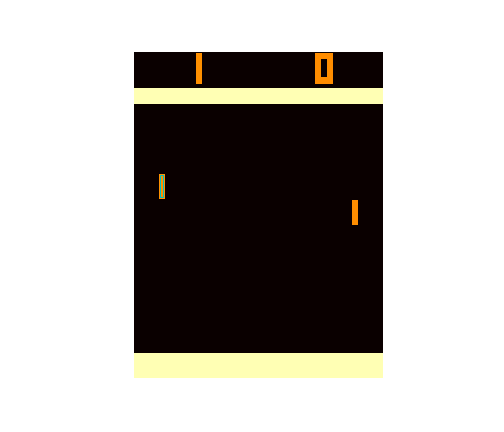
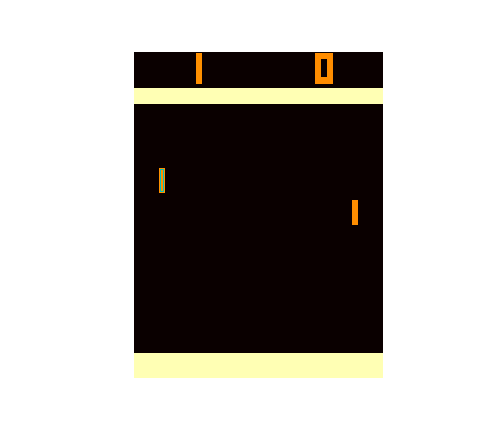
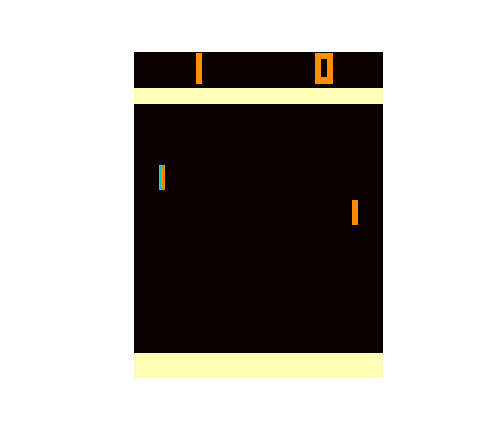

In [161]:
display_frames_as_gifB(frames[1:],rects)

In [162]:
ob02 = [[ob for ob in frame_obs if ob[0]==2 or ob[0]==0] for frame_obs in object_history ]
ob0 = [[ob for ob in frame_obs if ob[0]==0] for frame_obs in object_history ]
ob2 = [[ob for ob in frame_obs if ob[0]==2] for frame_obs in object_history ]

In [163]:
for i in range(len(ob0)):
    print("\nFrame : {}".format(i))
    if len(ob0[i])>0:
        print("Paddle: {}".format(ob0[i][0][1]))
    if len(ob2[i])>0:
        print("Ball  : {}".format(ob2[i][0][1]))




Frame : 0

Frame : 1

Frame : 2

Frame : 3

Frame : 4

Frame : 5

Frame : 6

Frame : 7

Frame : 8

Frame : 9

Frame : 10

Frame : 11

Frame : 12

Frame : 13

Frame : 14

Frame : 15

Frame : 16

Frame : 17
Paddle: (17, 116)

Frame : 18
Paddle: (16, 117)
Ball  : (76, 118)

Frame : 19
Paddle: (16, 121)
Ball  : (71, 122)

Frame : 20
Paddle: (16, 125)
Ball  : (68, 125)

Frame : 21
Paddle: (16, 129)
Ball  : (64, 129)

Frame : 22
Paddle: (16, 131)
Ball  : (61, 132)

Frame : 23
Paddle: (16, 135)
Ball  : (58, 135)

Frame : 24
Paddle: (16, 137)
Ball  : (55, 138)

Frame : 25
Paddle: (16, 141)
Ball  : (52, 141)

Frame : 26
Paddle: (16, 143)
Ball  : (49, 144)

Frame : 27
Paddle: (16, 147)
Ball  : (46, 147)

Frame : 28
Paddle: (16, 149)
Ball  : (44, 149)

Frame : 29
Paddle: (16, 151)
Ball  : (41, 152)

Frame : 30
Paddle: (16, 155)
Ball  : (37, 156)

Frame : 31
Paddle: (16, 159)
Ball  : (33, 160)

Frame : 32
Paddle: (16, 163)
Ball  : (30, 163)

Frame : 33
Paddle: (16, 167)
Ball  : (26, 167)

Frame :

In [165]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import svm

import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [166]:
# Representing the full game state, possible denormalized
# What objects exist
# For each object, what is its location and type
# What models are working, 
#     what objects they're tracking, 
#     for how how many timesteps they've been working, 
#     features when model started working (object (x,y), object appear, object collision (with which object), other model stopped working) 
# Collisions currently happening.
# All object types we know to exist and their size
# All model types we've attempted and their success (is it important to keep failures? Probably for a certain amount of time (ie 10000 frames))


In [167]:
class Game:
    def __init__(
        self,
        env_name,
        testing_array
    ):
        self.env_name = env_name
        
        self.object_list = []
        self.model_list = []        
        self.object_history = []
        self.frames = []
        self.diffs = []
        self.models = {}
        self.predictions = {}
        
        # Used for precomputed object trajectories
        self.testing_array = testing_array
        
    def frame_count(self):
        return len(self.object_history)

    def should_continue(self):
        return self.frame_count() < len(self.testing_array)
    
    def object_state(self):
        new_ob = self.testing_array[self.frame_count()]
        return new_ob
    
    def last_object_state(self):
        if len(self.object_history) == 0: return self.object_state()
        return self.object_history[-1]
                
class Model:
    def __init__(
        self,
        model_type,
        start_frame,
        base # scikit learn instance
    ):
        self.start_frame = start_frame
        self.model_type = model_type
        self.base = base 

class ModelType:
    def __init__(
        self,
        number,        
        params,
        features, #obj numbers
    ):
        self.number = number
        self.number = number
        self.params = params
        self.features = features

class Obj:
    def __init__(
        self,
        obj_type,
        location,
        start_frame,
    ):
        self.location = location
        self.obj_type = obj_type
        self.start_frame = start_frame
        self.models = []
        

class ObjType:
    def __init__(
        self,
        pixels,
        number
    ):
        self.pixels = pixels
        self.number = number
    
    def shape(self):
        return arr.shape

class StateDelta:
    def __init__(
        self,
        name,
        old_value,
        new_value,
    ):
        self.name = name
        self.old_value = old_value
        self.new_value = new_value
        
    def diff(self):
        if self.new_value is None or self.old_value is None:
            return "-"
        return self.new_value - self.old_value
        
    def info(self):
        print("Name {} | Old {} | New {} | Delta {}".format(self.name, self.old_value, self.new_value, self.diff()))
    

In [192]:
# lets generate a model for frames 0 - 35
# display_frames_as_gifB(frames[0:35])
# Takes an object_history state 
# ie (0, [[0, (16, 123)], [2, (70, 123)]]
# Returns dictionary of state_object:value diff pairs 
# ie {"0_x":16, "0_y":123} 
def parse_states(state_arr):
    parsed = {}
    for state in state_arr:
        parsed[str(state[0])+"_x"] = state[1][0]
        parsed[str(state[0])+"_y"] = state[1][1]
    return parsed


def states_delta(old_states, new_states):
    
    old_dict = parse_states(old_states) 
    new_dict = parse_states(new_states)
    
    deltas = {}
    if old_dict is not None:
        for key, old_val in old_dict.iteritems():
            new_val = new_dict.get(key,None)
            if new_val != old_val:
                deltas[key] = StateDelta(key, old_val, new_val)
            new_dict.pop(key, None) #prevent duplicates
            
    if new_dict is not None:
        for key, new_val in new_dict.iteritems():
            old_val = old_dict.get(key,None)
            if new_val != old_val:
                deltas[key] = StateDelta(key, old_val, new_val)

    return deltas


def delta_value(sd,key):
    delta = sd.get(key,None)
    if delta is not None:
        return delta.diff()
    else:
        return 0        

In [169]:
print ob02

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [[0, (17, 116)]], [[0, (16, 117)], [2, (76, 118)]], [[0, (16, 121)], [2, (71, 122)]], [[0, (16, 125)], [2, (68, 125)]], [[0, (16, 129)], [2, (64, 129)]], [[0, (16, 131)], [2, (61, 132)]], [[0, (16, 135)], [2, (58, 135)]], [[0, (16, 137)], [2, (55, 138)]], [[0, (16, 141)], [2, (52, 141)]], [[0, (16, 143)], [2, (49, 144)]], [[0, (16, 147)], [2, (46, 147)]], [[0, (16, 149)], [2, (44, 149)]], [[0, (16, 151)], [2, (41, 152)]], [[0, (16, 155)], [2, (37, 156)]], [[0, (16, 159)], [2, (33, 160)]], [[0, (16, 163)], [2, (30, 163)]], [[0, (16, 167)], [2, (26, 167)]], [[0, (16, 169)], [2, (24, 169)]], [[0, (18, 171)], [2, (22, 171)]], [[0, (16, 173)], [2, (20, 173)]], [[0, (16, 169)], [2, (21, 170)]], [[0, (16, 167)], [2, (23, 166)]], [[0, (16, 163)], [2, (25, 162)]], [[0, (16, 155)], [2, (29, 154)]], [[0, (16, 151)], [2, (32, 148)]], [[0, (16, 143)], [2, (36, 140)]], [[0, (16, 139)], [2, (39, 134)]], [[0, (16, 135)], [2, (41, 130

In [246]:
#predictions = {"m1_0_x": -3, "m2_0_x":-1, "m1_0_y":4}
#predictions = {"0_x":{"model_0x_0":-3, "model_0x_1":-1}, "o_y":{"model_0y_0":4}}
from sklearn import ensemble
start_state = 38
game = Game(game_name, testing_array=ob02[start_state:65])
# Game loop
values_2 = []
values_2_x = []
values_2_y = []



# need to track both STATE and LABELS for regression
# Meaning all the state of all the objects, and state deltas.
# Also all the target values we eventually want to predict
# Maybe an object should hold all this - because it is just a single set of values over time that need to be organized

class History:
    def __init__(
        self,
        object_history
    ):
        self.object_history = object_history
        
    def history_for_object(self, number):
        objects = [state[1] for state in game_state if state[0]==number]
        if len(objects>1):
            raise Exception("Multiple objects of the same type not yet supported")
        return objects[0]

template_focus = 0

while (game.should_continue()):
    game_state = game.object_state()
    sd = states_delta(game.last_object_state(), game_state)
    print(game.frame_count(), game_state)
    [delta.info() for name, delta in sd.iteritems()]
    
    # x_0, y_0, d_x_0, d_y_0
    
    values_2_item = []
    #filter for object 0
    object_2s = [state[1] for state in game_state if state[0]==template_focus]
    
    x, y = object_2s[0]
    
    values_2_item.append(x)
    values_2_item.append(y)

    values_2_item.append(delta_value(sd, str(template_focus)+"_x"))
    values_2_item.append(delta_value(sd, str(template_focus)+"_y"))
    values_2.append(values_2_item)
    
    values_2_x.append(x)
    values_2_y.append(y)
    
    game.object_history.append(game_state)


(0, [[0, (16, 167)], [2, (23, 166)]])
(1, [[0, (16, 163)], [2, (25, 162)]])
Name 2_x | Old 23 | New 25 | Delta 2
Name 2_y | Old 166 | New 162 | Delta -4
Name 0_y | Old 167 | New 163 | Delta -4
(2, [[0, (16, 155)], [2, (29, 154)]])
Name 2_x | Old 25 | New 29 | Delta 4
Name 2_y | Old 162 | New 154 | Delta -8
Name 0_y | Old 163 | New 155 | Delta -8
(3, [[0, (16, 151)], [2, (32, 148)]])
Name 2_x | Old 29 | New 32 | Delta 3
Name 2_y | Old 154 | New 148 | Delta -6
Name 0_y | Old 155 | New 151 | Delta -4
(4, [[0, (16, 143)], [2, (36, 140)]])
Name 2_x | Old 32 | New 36 | Delta 4
Name 2_y | Old 148 | New 140 | Delta -8
Name 0_y | Old 151 | New 143 | Delta -8
(5, [[0, (16, 139)], [2, (39, 134)]])
Name 2_x | Old 36 | New 39 | Delta 3
Name 2_y | Old 140 | New 134 | Delta -6
Name 0_y | Old 143 | New 139 | Delta -4
(6, [[0, (16, 135)], [2, (41, 130)]])
Name 2_x | Old 39 | New 41 | Delta 2
Name 2_y | Old 134 | New 130 | Delta -4
Name 0_y | Old 139 | New 135 | Delta -4
(7, [[0, (16, 127)], [2, (45, 12

In [247]:
    
#     # Features in for x_0 -> current x_0, delta_x_0, current y_0, delta_y_0

#     params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
#               'learning_rate': 0.01, 'loss': 'ls'}
#     clf = ensemble.GradientBoostingRegressor(**params)

#     clf.fit(X_train, y_train)
#     mse = mean_squared_error(y_test, clf.predict(X_test))
#     print("MSE: %.4f" % mse)
    
#     # Evaluate predictions
#     for state_name, deltas in game.predictions.iteritems():
#         for model_name, delta in deltas.iteritems():
#             if delta == sd.get(state_name, None): 
#                 # predictive
#                 models.upregulate(model_name, game_state)
#             else:
#                 models.downregulate(model_name, game_state)
#                 # not predictive, create model            
#                 models.create(delta, game_state)
            
    # Create new predictions
#     for name, d in sd.iteritems():
#         d.info()
#         is_predicited = False
#         for model in game.models[d.name]:
#             if model.is_predictive(game_state, d.new_value):
#                 game.predictions[i] = model.predict(game.object_history[i+1])
            

In [248]:
print(len(values_2))
from sklearn.model_selection import train_test_split
X_train_x, X_test_x, y_train_x, y_test_x = train_test_split(values_2[:-1], values_2_x[1:], test_size=0.5, random_state=24)
X_train_y, X_test_y, y_train_y, y_test_y = train_test_split(values_2[:-1], values_2_y[1:], test_size=0.5, random_state=24)

27


In [249]:
# params = {'n_estimators': 200, 'max_depth': 4, 'min_samples_split': 2, 'learning_rate': 0.01, 'loss': 'ls'}
# x2_model = ensemble.GradientBoostingRegressor(**params)
# y2_model = ensemble.GradientBoostingRegressor(**params)
x2_model = linear_model.LinearRegression()
y2_model = linear_model.LinearRegression()
x2_model.fit(X_train_x, y_train_x)
y2_model.fit(X_train_y, y_train_y)
mse_x = mean_squared_error(y_test_x, x2_model.predict(X_test_x))
mse_y = mean_squared_error(y_test_y, y2_model.predict(X_test_y))

print(X_train_x[0])
print("X Coef", x2_model.coef_)
print("X Intercept", x2_model.intercept_)
print("X MSE: %.4f" % mse_x)
print("Y MSE: %.4f" % mse_y)



[16, 107, 0, -4]
('X Coef', array([ 0.,  0.,  0.,  0.]))
('X Intercept', 16.0)
X MSE: 0.0000
Y MSE: 3.3473


In [255]:
#Rollout from last observed state
print(values_2[0])
old_x, old_y, old_delta_x, old_delta_y = values_2[0]

frames_later = 0
target = []
obj_shape = object_templates[template_focus].shape

for i in range(frames_later):
    last_object_state = [[old_x, old_y, old_delta_x, old_delta_y]]
    new_x = round(x2_model.predict(last_object_state)[0])
    new_y = round(y2_model.predict(last_object_state)[0])
    rectangles = [[old_x,old_y,old_x+obj_shape[1],old_y+obj_shape[0], "g"]]
    target.append(rectangles)

    old_delta_x = new_x - old_x
    old_delta_y = new_y - old_y
    old_x = new_x
    old_y = new_y

print("rollout:","x", round(old_x), "y", round(old_y))
print("true:","x", values_2[frames_later][0], "y", values_2[frames_later][1])


[16, 167, 0, 0]
('rollout:', 'x', 16.0, 'y', 167.0)
('true:', 'x', 16, 'y', 167)


In [225]:
# color_map = {"0":"c", "1":"g", "2":"r", "3":"w", "4":"m", "5":"y", "6":"b"}
# target = []
# length = 50
# for i in range(length-frames_later):
#     #obs: [num, [x,y]]
#     #cluster: xmin, ymin, xmax, ymax, color
#     #object: 2d array
#     obj_shape = object_templates[2].shape
#     rectangles = [[old_x,old_y,old_x+obj_shape[1],old_y+obj_shape[0], "w"]]
#     target.append(rectangles)
# print(target)

Loading 26 frames... 19%38%57%76%


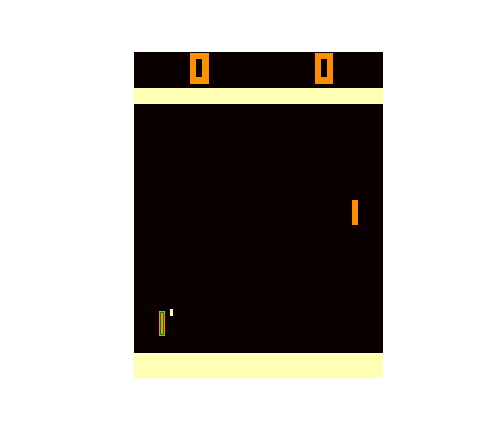
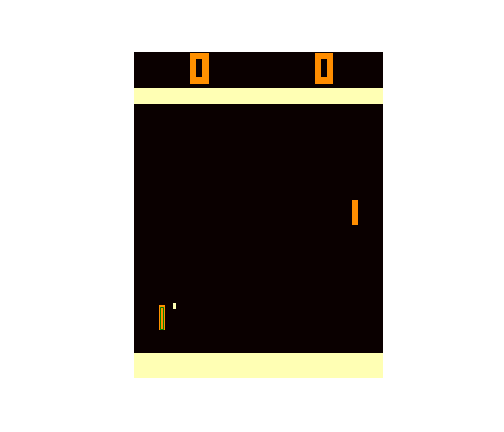
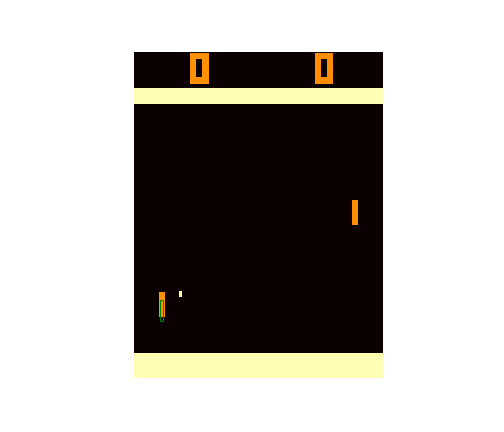
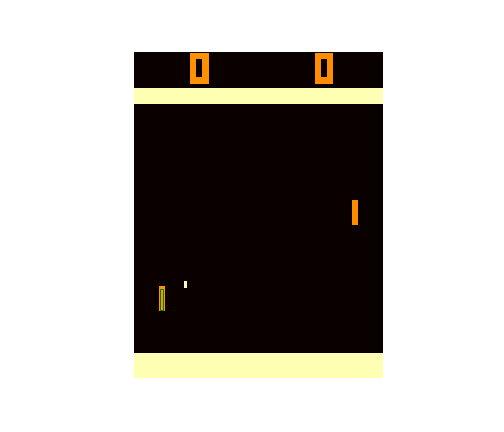
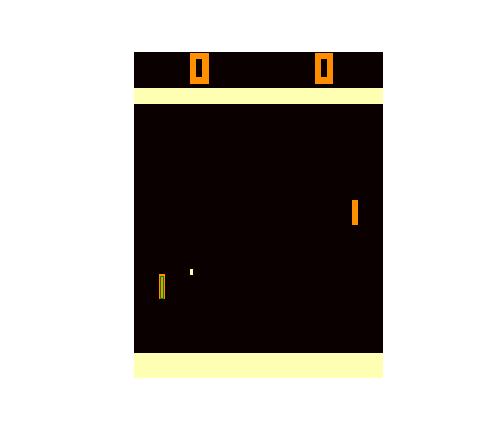
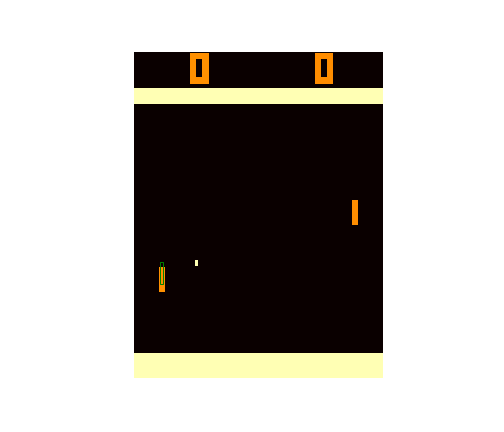
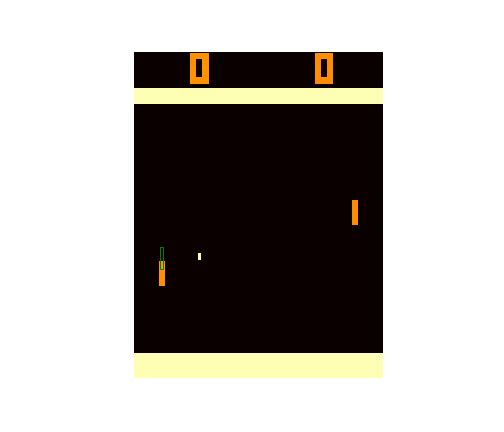
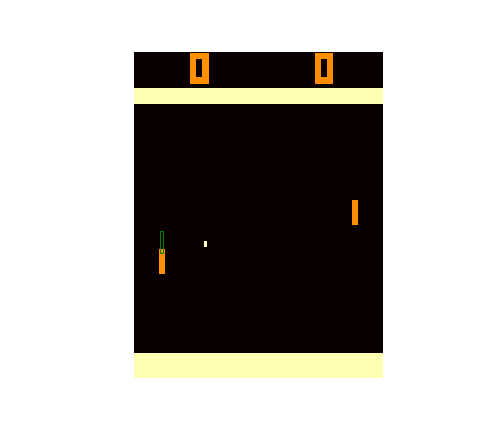
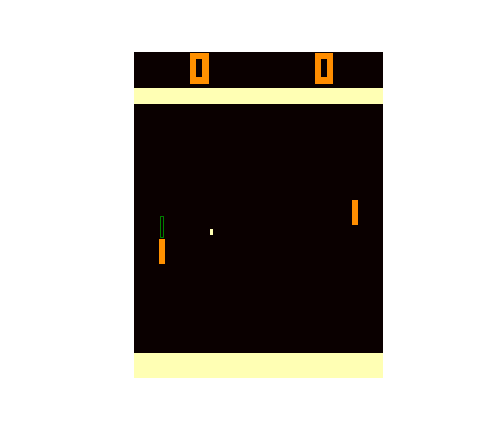
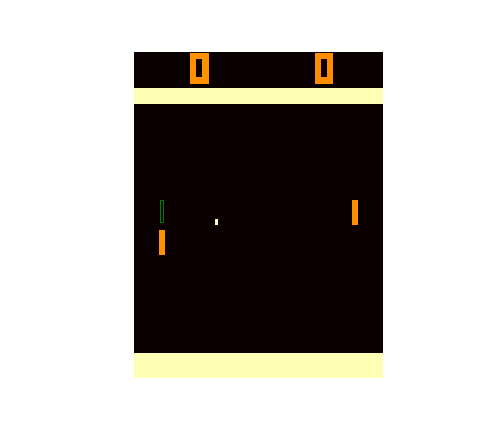
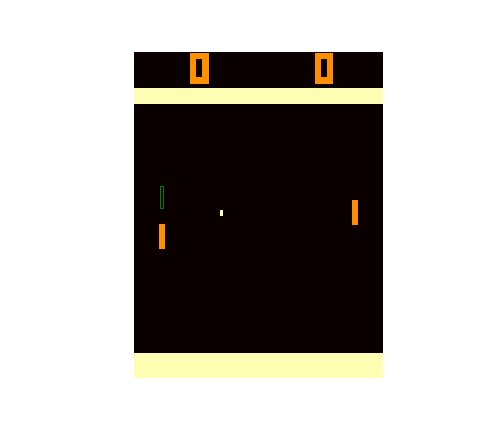
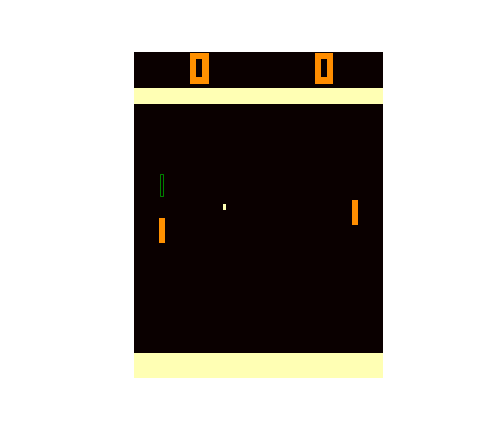
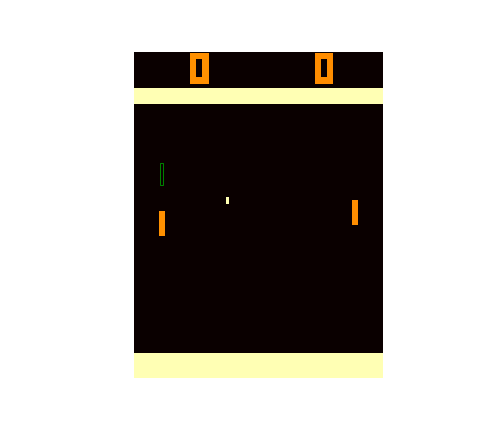
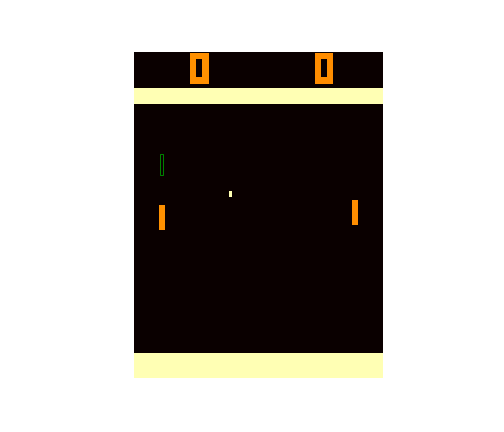
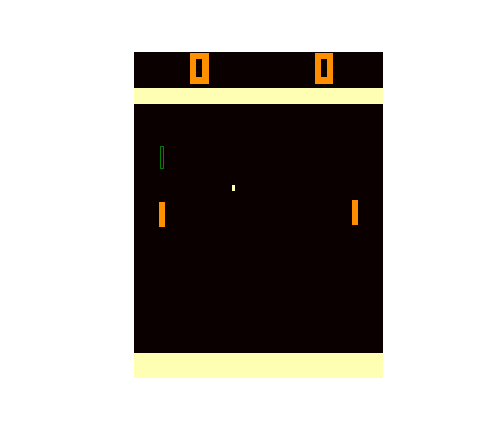
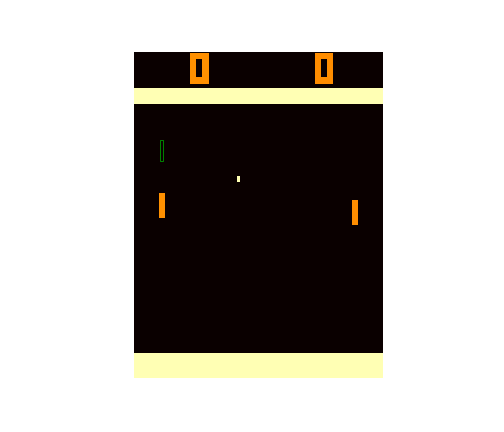
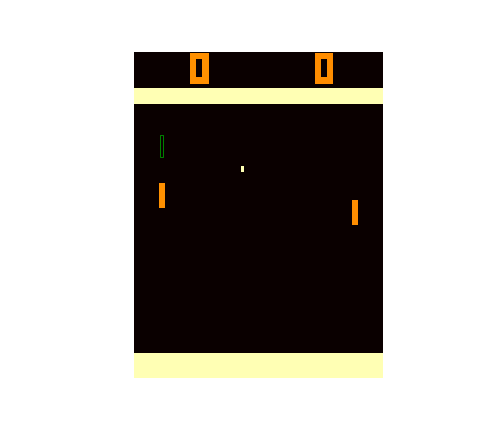
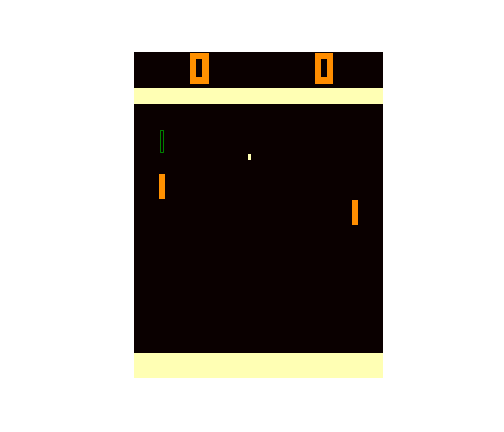
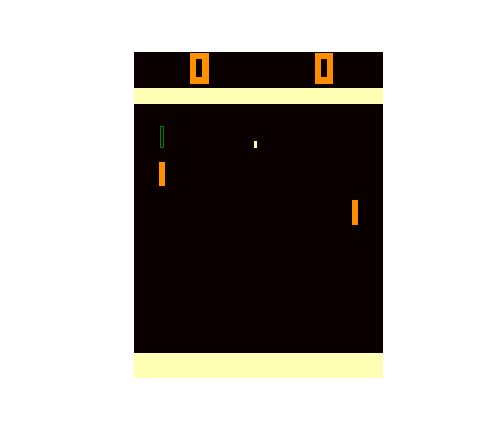
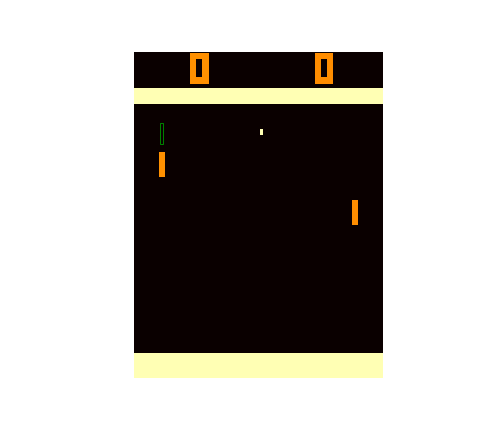
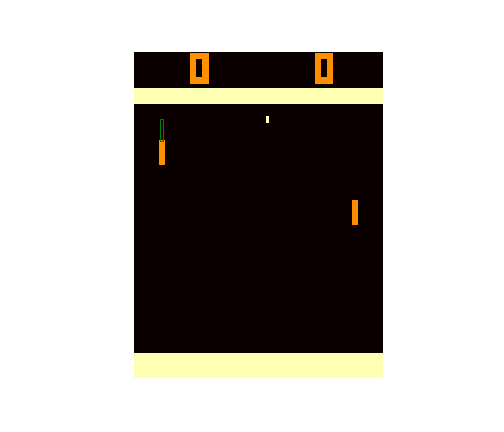
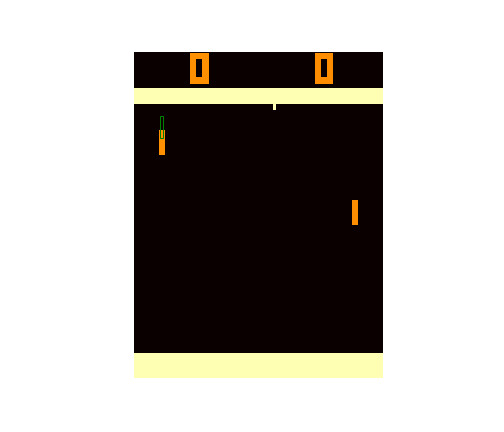
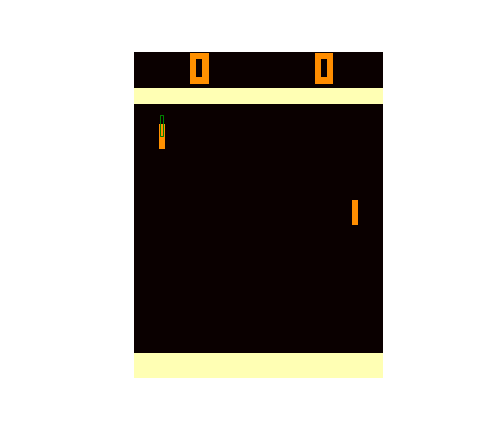
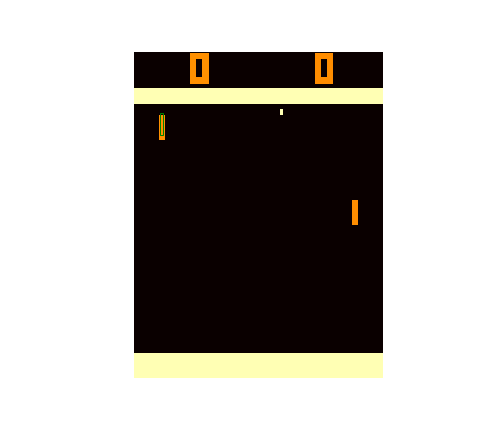
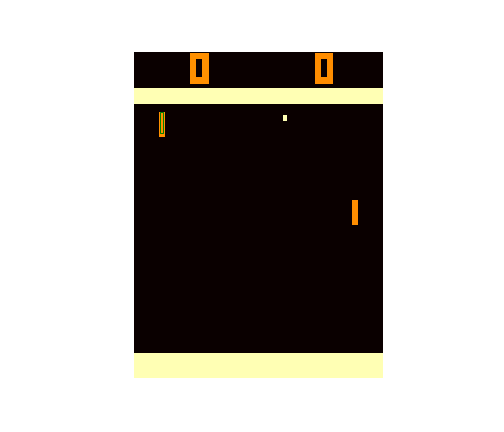

In [230]:
display_frames_as_gifB(frames[39:65], target)

For each object template, subsystem that
Has a 'regression' classifier for each substate (ie X, Y)
- used to determine, based on current (full/delta-modified) state, which regressor is most predictive
- labels (Y) are whether a given model was 'predictive' (true/false) for a given state
- data (X) is the state-model pair
- Plan A) Use regressor with heighest 'predicitve' score for the current state (classified)
- Plan B) No regressors seem promising, try them all anyway. If this point is reached in a rollout, give signal for exploration and terminate rollout.
- Plan C) If a regressor was predictive, update classifier. If none were, create a new regressor.
- if all the regressors were made with a substates that doesn't exist currently, a new regressor is created on all the historical frames that have the currently present substates

Has a set of substate regressors
- takes in all game state
- outputs a new substate prediction

Has an 'existence' classifier, for each template instance (ie 10 space invaders)
- Based on full game state, determines if the object will appear somewhere
- Contains two regressors to determine where

Rollouts query the subsystem with the entire game state
- all existence classifiers are queried with the current game state
- the existence classifier says whether the object is likely to exist at this time period
- if so, the regression classifier is asked which regressor is likely to be predictive here ( see above ABC)
- The chosen regressor gives a value for the substate (0_x..) and returns that to the rollout system